In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import confusion_matrix, pairwise_distances
from sklearn.manifold import TSNE
from itertools import chain
import time
import datetime
import pickle
import os

from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

import warnings
warnings.simplefilter("ignore")

<IPython.core.display.Javascript object>

In [20]:
def graph_to_matrix(G,weighted=False,directed=False): # convert a graph object into a matrix
    matrix = np.zeros((len(G.nodes()),len(G.nodes())))
    for edge in G.edges(data=True):
        if weighted:
            matrix[edge[0],edge[1]] = edge[2]['weight']
        else:
            matrix[edge[0],edge[1]] = 1
        if not directed:
            matrix[edge[1],edge[0]] = matrix[edge[0],edge[1]] 
    return matrix
    
def matrix_to_graph(matrix): # convert an adjacency matrix into a graph object
    G = nx.Graph().to_directed()
    for i in range(matrix.shape[0]):
        G.add_node(i)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i,j] != 0:
                G.add_edge(i, j, weight=matrix[i,j])
    return G

def ErdosRenyiGraph(n,p):
    return nx.erdos_renyi_graph(n, p).to_directed(),False,False

def dRegularGraph(n,d):
    return nx.random_regular_graph(d, n).to_directed(),False,False

def randomAdjacencyMatrix(n,p,directed=False,weighted=False): #ErdosRenyi is unweighted & undirected
    # matrix is in dimension nxn (i.e. n is the number of nodes)
    # p is probability for having non-zero entries
    # values of non-zero entries are sampled in Unif[0,1) if graph is weighted
    matrix = (np.random.rand(n, n) < p).astype(int)
    np.fill_diagonal(matrix, 0)
    if weighted:
        matrix = matrix * np.random.rand(n, n)
    if not directed:
        for i in range(n):
            for j in range(n):
                matrix[j,i] = matrix[i,j]
    return matrix,directed,weighted

def geometricAdjacencyMatrix(n,d,r,metric='euclidean'):
    '''
    Valid values for metric are:
    From scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]. These metrics support sparse matrix inputs. [‘nan_euclidean’] but it does not yet support sparse matrices.
    From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] See the documentation for scipy.spatial.distance for details on these metrics. These metrics do not support sparse matrix inputs.
    '''
    points = np.random.uniform(0, 1, size=(n, d))
    distance_matrix = (pairwise_distances(points, metric=metric) < r).astype(int)
    np.fill_diagonal(distance_matrix, 0)
    return distance_matrix,False,False

def ChungLuGraph(n,max_degree):
    degrees = np.random.choice(range(1,max_degree+1), n, replace=True)
    G = nx.Graph()
    for node, degree in enumerate(degrees):
        G.add_node(node, degree=degree)
    for u in G.nodes():
        for v in G.nodes():
            if u < v and np.random.rand() < G.nodes[u]['degree'] * G.nodes[v]['degree'] / (2 * sum(degrees)):
                    G.add_edge(u, v)
    return G.to_directed(),False,False

def gridGraph(nrows,ncols): # not random
    G = nx.Graph()
    for i in range(nrows):
        for j in range(ncols):
            G.add_node(i*ncols+j)
    for i in range(nrows):
        for j in range(ncols):
            if i < nrows - 1:
                G.add_edge(i*ncols+j, (i+1)*ncols+j)
            if j < ncols - 1:
                G.add_edge(i*ncols+j+1, i*ncols+j)
    return G.to_directed(),False,False

In [21]:
def closestSeed_networkx(G,u,S,return_path=False):
    closest_point = None
    smallest_distance = float('inf')
    shortest_path = []
    for s in S:
        if nx.has_path(G, u, s):
            path = nx.shortest_path(G, source=u, target=s, weight="weight")
            distance = sum(G[path[i]][path[i + 1]]["weight"] for i in range(len(path) - 1))
            if distance < smallest_distance:
                closest_point, smallest_distance, shortest_path = s, distance, path  
    if not return_path:
        return closest_point, smallest_distance
    else:
        return closest_point, smallest_distance, shortest_path

#### Das Sarma & Bourgain ####

def closestSeedFromStartPoint(graph, start, target_set, return_path=False):
    # Works for weighted & unweighted, directed & undirected graphs 
    # Doesn't allow self-directed nodes

    closest_point, smallest_weight, shortest_path = None, float('inf'), []
    target_set = [x for x in target_set if x != start]
    if len(target_set) > 0:
        visited = set()  # To keep track of visited vertices (vertices in paths stored in queue)
        queue = deque([(start, 0, [])])  # Initialize the queue with the starting vertex, its path, and the total weight
        storage = deque() # To store nodes removed from queue

        while queue:
            vertex, weight, path = queue.popleft()  # Dequeue a vertex, its path, and the total weight
            storage.append((vertex, weight))
            if vertex not in target_set:
                for neighbor, edge_weight in enumerate(graph[vertex]):
                    if neighbor not in path and neighbor != vertex and edge_weight != 0:
                        new_weight = weight + edge_weight
                        if neighbor not in visited:
                            queue.append((neighbor, new_weight, path + [vertex]))
                            visited.add(neighbor)
                        else: # Replace the path from 'start' to 'neighbor' in queue or storage with a shorter one if found
                            weight_info = [(index,item[1]) for index,item in enumerate(list(queue)) if item[0] == neighbor]
                            if len(weight_info) != 0:
                                for index, w in weight_info:
                                    if new_weight < w:
                                        del queue[index]
                                        queue.append((neighbor, new_weight, path + [vertex]))
                            else:
                                weights = [item[1] for item in storage if item[0] == neighbor]
                                if len(weights) > 0 and new_weight < np.min(weights):
                                    queue.append((neighbor, new_weight, path + [vertex]))

            elif vertex in target_set:
                if closest_point == None:
                    closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                else:
                    if weight < smallest_weight:
                        closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                k = len(queue)
                for i in range(k):
                    if smallest_weight <= queue[k-1-i][1]:
                        queue.remove(queue[k-1-i]) # Remove all paths in queue which are longer than the current shortest from 'start' to a seed
    
    if return_path:
        return closest_point, smallest_weight, shortest_path
    else:
        return closest_point, smallest_weight

def closestSeedToEndPoint(graph, target, start_set, return_path=False): 
    # Works for weighted & unweighted, directed & undirected graphs 
    # Doesn't allow self-directed nodes

    closest_point, smallest_weight, shortest_path = None, float('inf'), []
    start_set = [x for x in start_set if x != target]
    if len(start_set) > 0:
        visited = set()  # To keep track of visited vertices (vertices in paths stored in queue)
        queue = deque()  # Initialize the queue with the starting vertex, its path, and the total weight
        for i in range(len(start_set)):
            queue.append((start_set[i], 0, []))
        storage = deque()

        while queue:
            vertex, weight, path = queue.popleft()  # Dequeue a vertex, its path, and the total weight
            storage.append((vertex, weight))
            if vertex != target:
                for neighbor, edge_weight in enumerate(graph[vertex]):
                    if neighbor not in path and neighbor not in start_set and neighbor != vertex and edge_weight != 0:
                        new_weight = weight + edge_weight
                        if neighbor not in visited:
                            queue.append((neighbor, new_weight, path + [vertex]))
                            visited.add(neighbor)
                        else: # Replace the path from a start node to 'neighbor' in queue with a shorter one if found
                            weight_info = [(index,item[1]) for index,item in enumerate(list(queue)) if item[0] == neighbor]
                            if len(weight_info) != 0:
                                for index, w in weight_info:
                                    if new_weight < w:
                                        del queue[index]
                                        queue.append((neighbor, new_weight, path + [vertex]))
                            else:
                                weights = [item[1] for item in storage if item[0] == neighbor]
                                if len(weights) > 0 and new_weight < np.min(weights):
                                    queue.append((neighbor, new_weight, path + [vertex]))
                                
            else:
                if closest_point == None:
                    closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                else:
                    if weight < smallest_weight:
                        closest_point, smallest_weight, shortest_path = vertex, weight, path + [vertex]
                k = len(queue)
                for i in range(k):
                    if smallest_weight <= queue[k-1-i][1]:
                        queue.remove(queue[k-1-i]) # Remove all paths in queue which are longer than the current shortest from 'start' to a seed

    if return_path:
        return closest_point, smallest_weight, shortest_path
    else:
        return closest_point, smallest_weight

def offlineSample(G,u,node_to_sets=True):
    support = [n for n in range(G.shape[0]) if np.count_nonzero(G[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
    if len(support) == 0:
        return set()
    r = math.floor(np.log(len(support)))
    sample_sets = [np.random.choice(support,size=2**i,replace=False) for i in range(r+1)]
    if node_to_sets:
        closest_points = set([closestSeedFromStartPoint(G,u,S) for S in sample_sets])
    else:
        closest_points = set([closestSeedToEndPoint(G,u,S) for S in sample_sets])
    if (None,float('inf')) in closest_points:
        closest_points.remove((None,float('inf')))
    return closest_points,set(np.concatenate(sample_sets))

def offlineSketch(G,u,k,node_to_sets=True):
    closest_points,sample_sets = offlineSample(G,u,node_to_sets)
    for i in range(k):
        closest_points_new,sample_sets_new = offlineSample(G,u,node_to_sets)
        closest_points = closest_points.union(closest_points_new)
        sample_sets = sample_sets.union(sample_sets_new)
    return np.array(list(closest_points)),np.array(list(sample_sets))

def onlineShortestPath_Sarma(G,u,v,k,directed=False): ## upper bound
    if not directed:
        sketch_u,_ = offlineSketch(G,u,k)
        sketch_v,_ = offlineSketch(G,v,k)
    else:
        sketch_u,_ = offlineSketch(G,u,k)
    if sketch_u.shape[0] != 0 and sketch_v.shape[0] != 0:
        common_nodes = [w for w in sketch_u[:,0] if w in sketch_v[:,0]]
        while None in common_nodes:
            common_nodes.remove(None)
        min_dist = float('inf')
        for w in common_nodes:
            dist = sketch_u[sketch_u[:, 0] == w][0,1] + sketch_v[sketch_v[:, 0] == w][0,1]
            if dist < min_dist:
                min_dist = dist
        return min_dist
    else:
        return float('inf')

def onlineShortestPath_Bourgain(G,u,v,directed=False): ## lower bound
    support = [n for n in range(G.shape[0]) if np.count_nonzero(G[n]) >= 2 and n != u] # u is removed from the support for sampling seed sets
    r = math.floor(np.log(len(support)))
    sample_sets = [np.random.choice(support,size=2**i,replace=False) for i in range(r+1)]
    if directed:
        d_u_S = [closestSeedFromStartPoint(G,u,S)[1] for S in sample_sets]
        d_v_S = [closestSeedFromStartPoint(G,v,S)[1] for S in sample_sets]
        d_S_u = [closestSeedToEndPoint(G,u,S)[1] for S in sample_sets]
        d_S_v = [closestSeedToEndPoint(G,v,S)[1] for S in sample_sets]
        to_remove = [idx for idx,val in enumerate(list(zip(d_u_S,d_v_S))) if val[0] == float('inf') or val[1] == float('inf')]
        d_u_S = np.array([value for index, value in enumerate(d_u_S) if index not in to_remove])
        d_v_S = np.array([value for index, value in enumerate(d_v_S) if index not in to_remove])
        to_remove = [idx for idx,val in enumerate(list(zip(d_S_u,d_S_v))) if val[0] == float('inf') or val[1] == float('inf')]
        d_S_u = np.array([value for index, value in enumerate(d_S_u) if index not in to_remove])
        d_S_v = np.array([value for index, value in enumerate(d_S_v) if index not in to_remove])
        return max([0,np.max(d_S_v-d_S_u),np.max(d_u_S-d_v_S)])
    else:
        d_u_S = [closestSeedFromStartPoint(G,u,S)[1] for S in sample_sets]
        d_v_S = [closestSeedFromStartPoint(G,v,S)[1] for S in sample_sets]
        to_remove = [idx for idx,val in enumerate(list(zip(d_u_S,d_v_S))) if val[0] == float('inf') or val[1] == float('inf')]
        d_u_S = np.array([value for index, value in enumerate(d_u_S) if index not in to_remove])
        d_v_S = np.array([value for index, value in enumerate(d_v_S) if index not in to_remove])
        return np.max(np.abs(d_u_S-d_v_S))

def shortestDistance_allNodes_Sarma(G,u,k,directed=False):
    distances = np.zeros(G.shape[0])
    for v in range(G.shape[0]):
        if u != v:
            distances[v] = onlineShortestPath_Sarma(G,u,v,k,directed)
    return distances

def shortestDistance_allNodes_Bourgain(G,u,directed=False):
    distances = np.zeros(G.shape[0])
    for v in range(G.shape[0]):
        if u != v:
            distances[v] = onlineShortestPath_Bourgain(G,u,v,directed)
    return distances

def shortestDistance_allNodes_networkx(G,u):
    if isinstance(G, np.ndarray):
        G = matrix_to_graph(G)
    n_nodes = len(G.nodes())
    distances = np.zeros(n_nodes)
    for v in range(n_nodes):
        if u != v:
            if nx.has_path(G, u, v):
                distances[v] = nx.shortest_path_length(G, u, v)
            else:
                distances[v] = float('inf')       
    return distances

In [22]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, hidden_channels3, hidden_channels4, hidden_channels5, out_channels, sigmoid = False, reLU = False):
        super(MLP, self).__init__()
        #torch.manual_seed(12345)
        self.name = 'mlp'
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.width = hidden_channels1
        self.n_hidden_layers = 5
        self.lin1 = Linear(in_channels, hidden_channels1)
        self.lin2 = Linear(hidden_channels1, hidden_channels2)
        self.lin3 = Linear(hidden_channels2, hidden_channels3)
        self.lin4 = Linear(hidden_channels3, hidden_channels4)
        self.lin5 = Linear(hidden_channels4, hidden_channels5)
        self.lin6 = Linear(hidden_channels5, out_channels)
        if sigmoid:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None
        if reLU:
            self.reLU = torch.nn.ReLU()
        else:
            self.reLU = None

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        if self.sigmoid != None:
            x = self.sigmoid(x)
        if self.reLU != None:
            x = self.reLU(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, hidden_channels3, hidden_channels4, hidden_channels5, out_channels, sigmoid = False, reLU = False):
        super(GCN, self).__init__()
        #torch.manual_seed(1234567)
        self.name = 'gcn'
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.width = hidden_channels1
        self.n_hidden_layers = 5
        self.conv1 = GCNConv(in_channels, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.conv4 = GCNConv(hidden_channels3, hidden_channels4)
        self.conv5 = GCNConv(hidden_channels4, hidden_channels5)
        self.conv6 = GCNConv(hidden_channels5, out_channels)
        if sigmoid:
            self.sigmoid = torch.nn.Sigmoid()
        else:
            self.sigmoid = None
        if reLU:
            self.reLU = torch.nn.ReLU()
        else:
            self.reLU = None

    def forward(self, x, edge_index, weights=None):
        if weights == None:
            x = self.conv1(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv4(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv5(x, edge_index)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv6(x, edge_index)
        else:
            x = self.conv1(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv2(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv3(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv4(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv5(x, edge_index, edge_weight=weights)
            x = x.relu()
            x = F.dropout(x, p=0.5, training=self.training)
            x = self.conv6(x, edge_index, edge_weight=weights)
        if self.sigmoid != None:
            x = self.sigmoid(x)
        if self.reLU != None:
            x = self.reLU(x)
        return x

def build(in_channels,out_channels,model,criterion_type,optimizer_type,scheduler_type = None):
    
    if isinstance(model, str):
        hidden_channels1 = 256
        hidden_channels2 = 128
        hidden_channels3 = 64
        hidden_channels4 = 32
        hidden_channels5 = 8
        if model == 'mlp':
            if criterion_type in ['ce','bce','multimargin']:
                model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,sigmoid = True)
            elif criterion_type in ['mse','l2','l1']: 
                model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,reLU = True)
            else:
                model = MLP(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels)
        elif model == 'gcn':
            if criterion_type in ['ce','bce','multimargin']:
                model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,sigmoid = True)
            elif criterion_type in ['mse','l2','l1']: 
                model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels,reLU = True)
            else:
                model = GCN(in_channels,hidden_channels1,hidden_channels2,hidden_channels3,hidden_channels4,hidden_channels5,out_channels)
        else:
            raise ValueError(
                "Model type not yet defined."
            )
    
    if criterion_type == 'ce':
        criterion = [torch.nn.CrossEntropyLoss()]
    elif criterion_type == 'bce':
        criterion = [torch.nn.BCELoss()]
    elif criterion_type == 'bcelogits':
        criterion = [torch.nn.BCEWithLogitsLoss()]
    elif criterion_type in ['mse','l2']:
        criterion = [torch.nn.MSELoss()]
    elif criterion_type == 'l1':
        criterion = [torch.nn.L1Loss()]
    elif criterion_type == 'multimargin': # cuda crashed (similar to focal loss)
        criterion = [torch.nn.MultiMarginLoss()]
    elif criterion_type == 'mse-mse':
        criterion1 = torch.nn.MSELoss()
        criterion2 = torch.nn.MSELoss()
        criterion = [criterion1,criterion2]
    else:
        raise ValueError(
            "Criterion type not yet defined."
        )
    
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    elif optimizer_type == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
    elif optimizer_type == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.0001, alpha=0.99, eps=1e-8, momentum=0.9)
    elif optimizer_type == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.0001, lr_decay=0.0001)
    else:
        raise ValueError(
            "Optimizer type not yet defined."
        )
    
    if scheduler_type == None:
        scheduler = None
    else:
        if scheduler_type == 'step':
            scheduler = [torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)]
        elif scheduler_type == 'reduce_on_plateau':
            scheduler = [torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=False)]
        elif scheduler_type == 'exponential':
            scheduler = [torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)]
        elif scheduler_type == 'cosine':
            scheduler = [torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)]
        elif scheduler_type == 'cyclic':
            if optimizer_type in ['sgd','rmsprop']:
                scheduler = [torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, cycle_momentum=True)]
            else:
                scheduler = [torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, cycle_momentum=False)]
        elif scheduler_type == 'cyclic-cosine':
            cycle_epochs = 5
            if optimizer_type in ['sgd','rmsprop']:
                scheduler_cyclic = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=cycle_epochs, cycle_momentum=True)
            else:
                scheduler_cyclic = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=cycle_epochs, cycle_momentum=False)
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cycle_epochs * 2)
            scheduler = [scheduler_cyclic,scheduler_cosine]
        else:
            raise ValueError(
                "Scheduler type not yet defined."
            )
    
    return model,criterion,optimizer,scheduler

In [23]:
def predict(gpu_bool,model,criterion_type,samples_x,samples_edge_index=None,samples_weights=None):
    y_pred = []
    if gpu_bool:
        model = model.to('cuda:1')
    model.eval()
    with torch.no_grad():
        if model.name == 'mlp':
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                else:
                    x = samples_x[i]
                out = model(x)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        elif samples_weights == None:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                out = model(x,edge_index)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
        else:
            for i in range(len(samples_x)):
                if gpu_bool:
                    x = samples_x[i].to('cuda:1')
                    edge_index = samples_edge_index[i].to('cuda:1')
                    weights = samples_weights[i].to('cuda:1')
                else:
                    x = samples_x[i]
                    edge_index = samples_edge_index[i]
                    weights = samples_weights[i]
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.append(pred.cpu())
    model = model.to('cpu')
    return np.array(y_pred)

def predict_allBatches(model,criterion_type,samples):
    gpu_bool = torch.cuda.is_available()
    y_pred_train = predict(gpu_bool, model, criterion_type, samples[0], samples[6], samples[9])
    y_pred_val = predict(gpu_bool, model, criterion_type, samples[1], samples[7], samples[10])
    y_pred_test = predict(gpu_bool, model, criterion_type, samples[2], samples[8], samples[11])
    return y_pred_train,y_pred_val,y_pred_test

In [24]:
def generateSamples_closestPoints_inner(n_samples,max_n_samples_per_graph,function,*args,**kwargs):
    samples_x = []
    samples_y1 = []
    samples_y2 = []
    samples_y3 = []
    samples_y4 = []
    samples_y5 = []
    samples_y6 = []
    samples_edge_index = []
    samples_weights = None
    not_disconnected_nodes = []
    object,directed,weighted = function(*args,**kwargs)
    if weighted:
        samples_weights = []
    if isinstance(object, np.ndarray):
        matrix_type = object
        object = matrix_to_graph(object)
    else:
        matrix_type = graph_to_matrix(object)
    n = len(object.nodes())
    i = 0
    while i<n_samples:
        #print(i)
        components = list(nx.strongly_connected_components(object))
        to_remove = [c.pop() for c in components if len(c) == 1]
        if len(to_remove) < len(object.nodes()):
            matrix_type = np.delete(matrix_type, to_remove, axis=0)
            matrix_type = np.delete(matrix_type, to_remove, axis=1)
            object.remove_nodes_from(to_remove)
            remaining = object.nodes()
            object = nx.relabel_nodes(object, {node: index for index, node in enumerate(object.nodes())})
            if weighted:
                weights = list(nx.get_edge_attributes(object,'weight').values())
                M = n*max(weights)  
            else:
                M = n
            n_new = len(object.nodes())
            j = 0
            #print('a')
            while i<n_samples and j<max_n_samples_per_graph:
                u = np.random.choice(range(n_new))
                x_final = np.zeros((n_new,1))
                x_final[u,0] = 1
                y1_final = shortestDistance_allNodes_networkx(object,u)
                y1_final = np.where(y1_final == float('inf'), M, y1_final)
                if matrix_type.shape[0] > 50:
                    y2_final = []
                    y3_final = []
                    y4_final = []
                    y5_final = []
                    y6_final = []
                else:
                    try:
                        y2_final = shortestDistance_allNodes_Bourgain(matrix_type,u)
                        y2_final = np.where(y2_final == float('inf'), M, y2_final)
                    except:
                        y2_final = []
                    try:
                        y3_final = shortestDistance_allNodes_Sarma(matrix_type,u,1)
                        y3_final = np.where(y3_final == float('inf'), M, y3_final)
                    except:
                        y3_final = []
                    try:
                        y4_final = shortestDistance_allNodes_Sarma(matrix_type,u,2)
                        y4_final = np.where(y4_final == float('inf'), M, y4_final)
                    except:
                        y4_final = []
                    try:
                        y5_final = shortestDistance_allNodes_Sarma(matrix_type,u,3)
                        y5_final = np.where(y5_final == float('inf'), M, y5_final)
                    except:
                        y5_final = []
                    try:
                        y6_final = shortestDistance_allNodes_Sarma(matrix_type,u,4)
                        y6_final = np.where(y6_final == float('inf'), M, y6_final)
                    except:
                        y6_final = []
                samples_x.append(torch.tensor(x_final.astype(np.float32), requires_grad=True))
                samples_y1.append(torch.tensor(y1_final).to(torch.float32))
                samples_y2.append(y2_final)
                samples_y3.append(y3_final)
                samples_y4.append(y4_final)
                samples_y5.append(y5_final)
                samples_y6.append(y6_final)
                samples_edge_index.append(torch.tensor(np.array(list(object.edges())).T).to(torch.int64))
                if weighted:
                    samples_weights.append(torch.tensor(weights).to(torch.float32))
                not_disconnected_nodes.append(remaining)
                i += 1
                j += 1
        else:
            object,directed,weighted = function(*args,**kwargs)
            if isinstance(object, np.ndarray):
                matrix_type = object
                object = matrix_to_graph(object)
            else:
                matrix_type = graph_to_matrix(object)
    return samples_x, [samples_y1, samples_y2, samples_y3, samples_y4, samples_y5, samples_y6], samples_edge_index, samples_weights,not_disconnected_nodes

def generateSamples_closestPoints(n_train,n_val,n_test,max_n_samples_per_graph,function,*args,**kwargs):
    x_train, y_train, edge_index_train, weights_train,not_disconnected_train = generateSamples_closestPoints_inner(n_train,max_n_samples_per_graph,function,*args,**kwargs)
    x_val, y_val, edge_index_val, weights_val,not_disconnected_val = generateSamples_closestPoints_inner(n_val,max_n_samples_per_graph,function,*args,**kwargs)
    x_test, y_test, edge_index_test, weights_test,not_disconnected_test = generateSamples_closestPoints_inner(n_test,max_n_samples_per_graph,function,*args,**kwargs)
    return [x_train, x_val, x_test, y_train, y_val, y_test, edge_index_train,edge_index_val,edge_index_test,weights_train,weights_val,weights_test,not_disconnected_train,not_disconnected_val,not_disconnected_test]

In [25]:
def evaluate_inner(plot_title,title,y,y_pred,true_distances,x_samples = None,classification=True): ## target is nx1

    if classification:

        graph_size = true_distances.shape[1]

        ## Calculate the proportion of points selected from the sample.
        ratio1 = np.mean(y_pred,axis=1)

        ## Check if any disconnected node is in actual sketch.
        true_distances[true_distances == np.inf] = -1 ## convert inf into a large number for the sake of calculations
        M = np.max(true_distances) * 10
        true_distances[true_distances == -1] = M
        y_actual = torch.stack(y).detach().numpy()
        dump_actual = y_actual*true_distances
        n_dump_actual_equal_M = np.sum((dump_actual == M).astype(int),axis=1)
        ratio2 = n_dump_actual_equal_M/np.sum(y_actual,axis=1) ## nan means empty sketch
        #ratio2[np.isnan(ratio2)] = -1

        ## Check if any disconnected node is chosen.
        dump = y_pred*true_distances
        n_true_distances_equal_M = np.sum((true_distances == M).astype(int),axis=1)
        n_dump_equal_M = np.sum((dump == M).astype(int),axis=1)
        n_selected = np.sum(y_pred,axis=1)
        n_selected[n_selected == 0] = 0.0001
        ratio3 = n_dump_equal_M/n_selected ## nan means no nodes have been selected, ratio1 = 0
        #ratio3[np.isnan(ratio3)] = -1

        if x_samples != None:

            ## Seed node and neighbors -> 1. Others -> 0
            seed_or_neighbors = np.zeros_like(true_distances)
            _,seeds = np.where(true_distances == 0) ## number of seeds = number of samples because we selected one seed from each sample
            seed_disconnected = np.zeros(seed_or_neighbors.shape[0])
            for i in range(len(seeds)):
                seed = seeds[i]
                seed_or_neighbors[i] = x_samples[i].detach().numpy()[seed] ## x_samples[i] has to be adjacency matrix
                seed_disconnected[i] = sum((seed_or_neighbors[i]>0).astype(int))>0
                seed_or_neighbors[i,seed] = 1
            seed_or_neighbors_selected = seed_or_neighbors*y_pred

            ## Is seed node not disconnected from the remaining?
            seed_disconnected = seed_disconnected.astype(int)

            ## Have seed node and its neighbors been chosen?
            ratio4 = np.sum(seed_or_neighbors_selected,axis=1)/np.sum(seed_or_neighbors,axis=1)

            ## How many of the chosen nodes are seed node and its neighbors?
            ratio5 = np.sum(seed_or_neighbors_selected,axis=1)/n_selected ## nan means no nodes have been selected, ratio1 = 0
            #ratio5[np.isnan(ratio5)] = -1

        ## Check if the chosen nodes are closer than random selection.
        sum_distance_selected = np.sum(dump,axis=1)
        term0 = np.mean(true_distances,axis=1)
        term0[term0 == 0] = 0.0001
        ratio6 = sum_distance_selected/n_selected/term0 ## nan means no nodes have been selected, ratio1 = 0
        #ratio6[np.isnan(ratio6)] = -1

        ## Same as ratio6 but excludes disconnected nodes with inf distance to the seed node.
        n_selected[n_selected == 0.0001] = 0
        term1 = n_selected-n_dump_equal_M
        term1[term1 == 0] = 0.0001
        term2 = np.sum(true_distances,axis=1)-n_true_distances_equal_M*M
        term2[term2 == 0] = 0.0001
        ratio7 = (sum_distance_selected-n_dump_equal_M*M)/term1/term2*(graph_size-n_true_distances_equal_M)
        #ratio7[np.isnan(ratio7)] = -1
        ## nan means no nodes have been selected (ratio1 = 0) or selected nodes are all disconnected from seed node (inf distance)

        plt.figure(figsize=(10, 5))
        plt.plot(range(len(ratio1)), ratio1, color = '#1f77b4', label = 'ratio 1: size of selected community to size of sample ratio',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio6, color = '#8c564b', label = 'ratio 2: mean distance of chosen nodes to seed node divided by mean distance of all nodes to seed node',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio7, color = '#e377c2', label = 'ratio 3: same as ratio 6 but excludes disconnected nodes',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio2, color = '#ff7f0e', label = 'ratio 4: proportion of disconnected nodes in actual sketch',alpha = 0.6)
        plt.plot(range(len(ratio1)), ratio3, color = '#2ca02c', label = 'ratio 5: proportion of disconnected nodes in the chosen community',alpha = 0.6)
        if x_samples != None:
            plt.plot(range(len(ratio1)), ratio4, color = '#d62728', label = 'ratio 6: proportion of seed node and its neighbors that are selected',alpha = 0.6)
            plt.plot(range(len(ratio1)), ratio5, color = '#9467bd', label = 'ratio 7: proportion of selected nodes that are seed node or its neighbors',alpha = 0.6)
            plt.scatter(range(len(ratio1)), seed_disconnected, color = 'k', marker='x', label = 'is seed node not disconnected from the remaining nodes in graph? 1 = True, 0 = False',alpha = 0.6)
        plt.xlabel("sample index")
        plt.ylabel("")
        plt.title(title)
        plt.legend(loc = 'lower center',bbox_to_anchor=(0.48, -0.6))
        plt.show()

        true_distances[true_distances == M] = np.inf
        if x_samples == None:
            return [np.mean(ratio1),np.mean(ratio6),np.mean(ratio7),np.mean(ratio2),np.mean(ratio3)]
        else:
            return [np.mean(ratio1),np.mean(ratio6),np.mean(ratio7),np.mean(ratio2),np.mean(ratio3),np.mean(ratio4),np.mean(ratio5)]
        
    else:
        y_actual = np.array(y[0])
        n_nodes = y_actual.shape[0]*y_actual.shape[1]
        diff_pred = (y_actual-y_pred).reshape(n_nodes)
        values, base = np.histogram(diff_pred, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], cumulative, label='GNN', alpha = 0.75)
        lengths = [len(x) for x in y[1]]
        if 0 not in lengths:
            y_Bourgain = np.array(y[1])
            diff_Bourgain = (y_actual-y_Bourgain).reshape(n_nodes)
            values, base = np.histogram(diff_Bourgain, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Bourgain', alpha = 0.75)
        lengths = [len(x) for x in y[2]]
        if 0 not in lengths:
            y_Sarma1 = np.array(y[2])
            diff_Sarma1 = (y_actual-y_Sarma1).reshape(n_nodes)
            values, base = np.histogram(diff_Sarma1, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Sarma, k=1', alpha = 0.75)
        lengths = [len(x) for x in y[3]]
        if 0 not in lengths:
            y_Sarma2 = np.array(y[3])
            diff_Sarma2 = (y_actual-y_Sarma2).reshape(n_nodes)
            values, base = np.histogram(diff_Sarma2, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Sarma, k=2', alpha = 0.75)
        lengths = [len(x) for x in y[4]]
        if 0 not in lengths:
            y_Sarma3 = np.array(y[4])
            diff_Sarma3 = (y_actual-y_Sarma3).reshape(n_nodes)
            values, base = np.histogram(diff_Sarma3, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Sarma, k=3', alpha = 0.75)
        lengths = [len(x) for x in y[5]]
        if 0 not in lengths:
            y_Sarma4 = np.array(y[5])
            diff_Sarma4 = (y_actual-y_Sarma4).reshape(n_nodes)
            values, base = np.histogram(diff_Sarma4, bins=100)
            cumulative = np.cumsum(values)
            plt.plot(base[:-1], cumulative, label='Sarma, k=4', alpha = 0.75)
        plt.xlabel("y_actual - y_pred")
        plt.ylabel("cummulative frequency")
        plt.title(plot_title+title)
        plt.legend()

        if plot_title == 'shortest distance regression: ':
            filenames = os.listdir(dir)
            if '0.png' not in filenames:
                plt.savefig(dir+'/0.png')
            else:
                filenames = sorted([int(f[:-4]) for f in filenames])
                plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   

        plt.show()
    
def evaluate(plot_title,model,criterion_type,samples,adjacency_matrix_available = False):
    if criterion_type in ['mse','l2','l1','mse-mse']:
        classification = False
    else:
        classification = True
    y_pred_train,y_pred_val,y_pred_test = predict_allBatches(model,criterion_type,samples)
    if adjacency_matrix_available:
        evaluate_inner(plot_title,'training data',samples[3],y_pred_train,samples[12],samples[0],classification)
        evaluate_inner(plot_title,'validation data',samples[4],y_pred_val,samples[13],samples[1],classification)
        evaluate_inner(plot_title,'test data',samples[5],y_pred_test,samples[14],samples[2],classification)
    else:
        evaluate_inner(plot_title,'training data',samples[3],y_pred_train,samples[12],classification=classification)
        evaluate_inner(plot_title,'validation data',samples[4],y_pred_val,samples[13],classification=classification)
        evaluate_inner(plot_title,'test data',samples[5],y_pred_test,samples[14],classification=classification)
    #return np.array(stats)

In [26]:
def test(gpu_bool,model,criterion,criterion_type,samples_x,samples_y,samples_edge_index = None,samples_weights = None):
    t_loss = 0
    total_samples = 0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        if samples_edge_index == None:
            for x,y in list(zip(samples_x,samples_y)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                out = model(x)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)
        elif samples_weights == None:
            for x,y,edge_index in list(zip(samples_x,samples_y,samples_edge_index)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                out = model(x,edge_index)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)
        else:
            for x,y,edge_index,weights in list(zip(samples_x,samples_y,samples_edge_index,samples_weights)):
                if gpu_bool:
                    x = x.to('cuda:1')
                    y = y.to('cuda:1')
                    edge_index = edge_index.to('cuda:1')
                    weights = weights.to('cuda:1')
                out = model(x,edge_index,weights)  # Perform a single forward pass.
                y_true.extend(y)
                if criterion_type in ['bce']:
                    t_loss += criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
                elif criterion_type == 'mse-mse':
                    t_loss += 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
                elif criterion_type in ['ce','multimargin']:
                    t_loss += criterion[0](out, y) ## classification
                else:
                    t_loss += criterion[0](out.squeeze(), y.to(torch.float32))
                total_samples += 1
                if criterion_type in ['bce','ce','multimargin']:
                    pred = out.argmax(dim=1) #  Use the class with highest probability.
                elif criterion_type in ['mse','l2','l1','mse-mse']:
                    pred = out.squeeze()
                else:
                    pred = torch.round(out.squeeze())
                y_pred.extend(pred)

    t_loss = t_loss/total_samples
    t_loss = t_loss.cpu()
    if criterion_type in ['mse','l2','l1','mse-mse']:
        return t_loss, None, None, None
    else:
        y_true = np.array([y.cpu() for y in y_true])
        y_pred = np.array([y.cpu() for y in y_pred])
        #print(np.array(y_true).shape)
        #print(np.array(y_pred).shape)
        t_accuracy = sum(y_true == y_pred)/len(y_true)
        cm = confusion_matrix(y_true, y_pred)
        #print(cm.ravel())
        tn, fp, fn, tp = cm.ravel()
        t_sensitivity = tp / (tp + fn)
        t_specificity = tn / (tn + fp)
        return t_loss, t_accuracy, t_sensitivity, t_specificity

def train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val,edge_index_train=None,edge_index_val=None,weights_train=None,weights_val=None):
    model.train()
    if edge_index_train == None:
        for x,y in list(zip(x_train,y_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
            out = model(x)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    elif weights_train == None:
        for x,y,edge_index in list(zip(x_train,y_train,edge_index_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
            out = model(x,edge_index)  # Perform a single forward pass
            #print(out.shape)
            #print(y.shape)
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.
    else:
        for x,y,edge_index,weights in list(zip(x_train,y_train,edge_index_train,weights_train)):
            optimizer.zero_grad()  # Clear gradients.
            if gpu_bool:
                x = x.to('cuda:1')
                y = y.to('cuda:1')
                edge_index = edge_index.to('cuda:1')
                weights = weights.to('cuda:1')
            out = model(x,edge_index,weights)  # Perform a single forward pass.
            if criterion_type in ['bce']:
                t_loss = criterion[0](out, torch.stack((1-y, y)).T.to(torch.float32))
            elif criterion_type == 'mse-mse':
                t_loss = 100*criterion[0](out[:, ::2], y[:, ::2]) + criterion[1](out[:, 1::2], y[:, 1::2])
            elif criterion_type in ['ce','multimargin']:
                t_loss = criterion[0](out, y) ## classification
            else:
                t_loss = criterion[0](out.squeeze(), y.to(torch.float32))
            t_loss.backward()  # Derive gradients
            optimizer.step()  # Update parameters based on gradients.

    train_loss, train_accuracy, train_sensitivity, train_specificity = test(gpu_bool,model,criterion,criterion_type,x_train,y_train,edge_index_train,weights_train)
    v_loss, v_accuracy, v_sensitivity, v_specificity = test(gpu_bool,model,criterion,criterion_type,x_val,y_val,edge_index_val,weights_val)

    if scheduler_type in ['step','exponential','cyclic','cosine']:
        scheduler[0].step()
    elif scheduler_type == 'reduce_on_plateau': 
        scheduler[0].step(v_loss)
    elif scheduler_type == 'cyclic-cosine':
        scheduler[0].step()
        scheduler[1].step()
    return train_loss,train_accuracy,train_sensitivity,train_specificity,v_loss,v_accuracy,v_sensitivity,v_specificity

def run(samples,model,criterion_type,optimizer_type,scheduler_type,num_epochs=100,early_stopping_patience=None,visualize = False,save_model = False):

    plot_title = 'shortest distance regression: '
    gpu_bool = torch.cuda.is_available()

    x_train = samples[0]
    x_val = samples[1]
    x_test = samples[2]
    y_train = samples[3][0]
    y_val = samples[4][0]
    y_test = samples[5][0]
    edge_index_train = samples[6]
    edge_index_val = samples[7]
    edge_index_test = samples[8]
    weights_train = samples[9]
    weights_val = samples[10]
    weights_test = samples[11]
    
    out_channels = 1
    if isinstance(model, str):
        model_type = model
        model,criterion,optimizer,scheduler = build(x_train[0].shape[1], out_channels, model_type,criterion_type,optimizer_type,scheduler_type)
    else:
        model_type = model.name
        _,criterion,optimizer,scheduler = build(x_train[0].shape[1], out_channels, model, criterion_type,optimizer_type,scheduler_type)
    print(model)

    if gpu_bool:
        model = model.to('cuda:1')
        
    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    train_loss = []
    train_acc = []
    train_sen = []
    train_spec = []
    val_loss = []
    val_acc = []
    val_sen = []
    val_spec = []

    if early_stopping_patience != None:
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement_count = 0

    for epoch in range(1, num_epochs+1):
        if model_type == 'mlp':
            #print(y_train[0].shape)
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,scheduler_type,x_train,x_val,y_train,y_val)
        else:
            #print(y_train[0].shape)
            t_loss,t_acc,t_sen,t_spec, v_loss, v_acc, v_sen, v_spec = train(gpu_bool,model,criterion,optimizer,scheduler,criterion_type,optimizer_type,x_train,x_val,y_train,y_val,edge_index_train,edge_index_val,weights_train,weights_val)
        train_loss.append(t_loss)
        train_acc.append(t_acc)
        train_sen.append(t_sen)
        train_spec.append(t_spec)
        val_loss.append(v_loss)
        val_acc.append(v_acc)
        val_sen.append(v_sen)
        val_spec.append(v_spec)
        #print(t_loss)
        #print(t_acc_or_error)
        if epoch % 10 == 0:
            if criterion_type in ['mse','l2','mse-mse']:
                print(f'Epoch: {epoch:03d}, Training Loss (MSE): {t_loss:.4f}, Validation Loss (MSE): {v_loss:.4f}')
            elif criterion_type == 'l1':
                print(f'Epoch: {epoch:03d}, Training Loss (MAE): {t_loss:.4f}, Validation Loss (MAE): {v_loss:.4f}')
            else:
                print(f'Epoch: {epoch:03d}, Training Loss: {t_loss:.4f}, Training Accuracy: {t_acc:.4f}, Training Sensitivity: {t_sen:.4f}, Training Specificity: {t_spec:.4f}, Validation Loss: {v_loss:.4f}, Validation Accuracy: {v_acc:.4f}, Validation Sensitivity: {v_sen:.4f}, Validation Specificity: {v_spec:.4f}')

        if early_stopping_patience != None:
            if v_loss < best_val_loss:
                best_val_loss = v_loss
                best_epoch = epoch
                no_improvement_count = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                no_improvement_count += 1
            if no_improvement_count >= early_stopping_patience:
                model.load_state_dict(torch.load('best_model.pth'))
                if gpu_bool:
                    model = model.to('cuda:1')
                break

    if model_type == 'mlp':
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test)
    else:
        test_loss, test_acc, test_sen, test_spec = test(gpu_bool,model,criterion,criterion_type,x_test, y_test, edge_index_test, weights_test)
    
    if early_stopping_patience == None:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')
    else:
        if criterion_type in ['mse','l2','mse-mse']:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MSE): {test_loss:03f}')
        elif criterion_type == 'l1':
            print(f'Best Epoch: {best_epoch:03d}, Test Loss (MAE): {test_loss:03f}')
        else:
            print(f'Best Epoch: {best_epoch:03d}, Test Loss: {test_loss:03f}, Test Accuracy: {test_acc:03f}, Test Sensitivity: {test_sen:03f}, Test Specificity: {test_spec:03f}')

    x = range(1, len(train_loss)+1)
    plt.plot(x, train_loss, color = '#1f77b4', label = 'training loss', alpha = 0.75)
    plt.plot(x, val_loss, color = '#ff7f0e', label = 'validation loss', alpha = 0.75)
    if criterion_type in ['ce','bce','bcelogits','multimargin']:
        plt.plot(x, train_acc, color = '#2ca02c', label = 'training accuracy', alpha = 0.75)
        plt.plot(x, val_acc, color = '#d62728', label = 'validation accuracy', alpha = 0.75)
        plt.plot(x, train_sen, color = '#9467bd', label = 'training sensitivity', alpha = 0.75)
        plt.plot(x, val_sen, color = '#8c564b', label = 'validation sensitivity', alpha = 0.75)
        plt.plot(x, train_spec, color = '#e377c2', label = 'training specificity', alpha = 0.75)
        plt.plot(x, val_spec, color = '#7f7f7f', label = 'validation specificity', alpha = 0.75)
    plt.xlabel("epoch")
    plt.ylabel("")
    plt.title("training results")
    plt.legend(loc = 'right',bbox_to_anchor=(1.45, 0.5))

    filenames = os.listdir(dir)
    if '0.png' not in filenames:
        plt.savefig(dir+'/0.png')
    else:
        filenames = sorted([int(f[:-4]) for f in filenames])
        plt.savefig(dir+'/'+str(filenames[-1]+1)+'.png')   

    plt.show()

    if visualize:
        model.eval()
        if model_type == 'mlp':
            out = model(x_test[0])
        else:
            out = model(x_test[0],edge_index_test[0])
        visualizeTNSE(out, color=y_test[0])

    model = model.to('cpu')
    if save_model:
        torch.save(model.state_dict(), 'trained_model_'+str(model.in_channels)+'_'+str(model.first_hidden_channels)+'_'+str(model.out_channels)+'_'+str(model.n_hidden_layers)+'.pth')
    
    evaluate(plot_title,model,criterion_type,samples,adjacency_matrix_available = False)

In [27]:
dir = 'dump'

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3916, Validation Loss (MSE): 1.0579
Epoch: 020, Training Loss (MSE): 0.3926, Validation Loss (MSE): 1.0402
Epoch: 030, Training Loss (MSE): 0.3921, Validation Loss (MSE): 1.0530
Epoch: 040, Training Loss (MSE): 0.3921, Validation Loss (MSE): 1.0575
Epoch: 050, Training Loss (MSE): 0.3921, Validation Loss (MSE): 1.0575
Test Loss (MSE): 0.429738


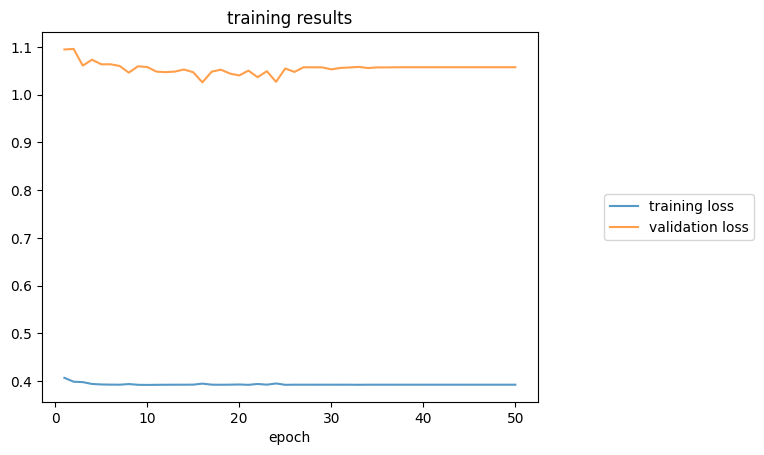

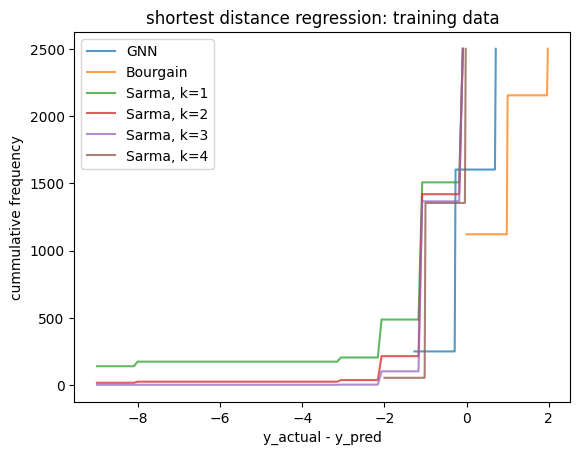

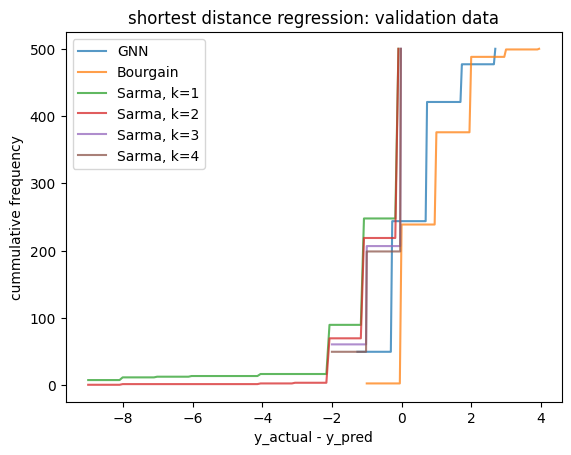

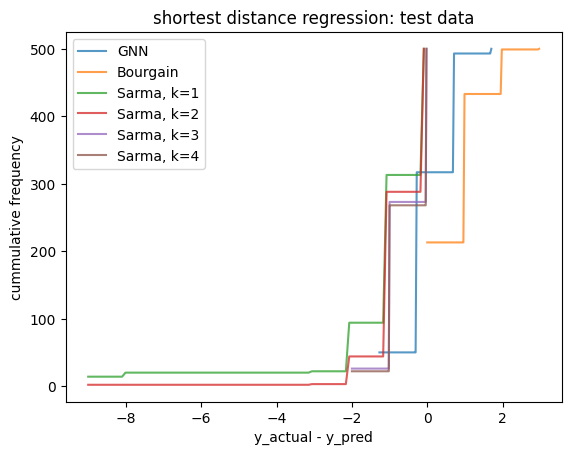

In [28]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,10,0.5)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3124, Validation Loss (MSE): 0.3148
Epoch: 020, Training Loss (MSE): 0.3125, Validation Loss (MSE): 0.3150
Epoch: 030, Training Loss (MSE): 0.3125, Validation Loss (MSE): 0.3150
Epoch: 040, Training Loss (MSE): 0.3125, Validation Loss (MSE): 0.3150
Epoch: 050, Training Loss (MSE): 0.3125, Validation Loss (MSE): 0.3150
Test Loss (MSE): 0.317841


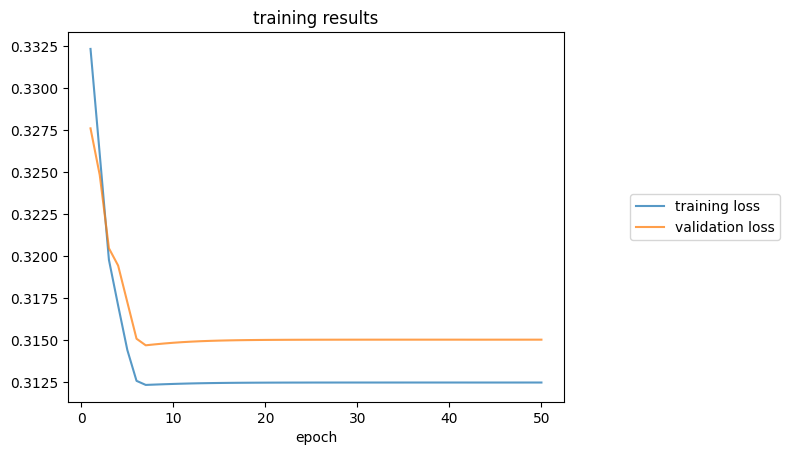

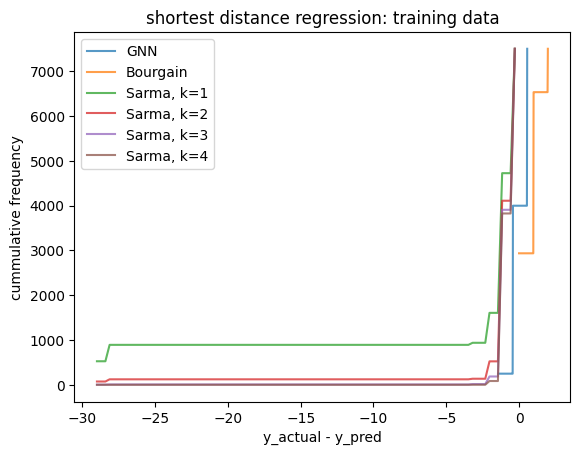

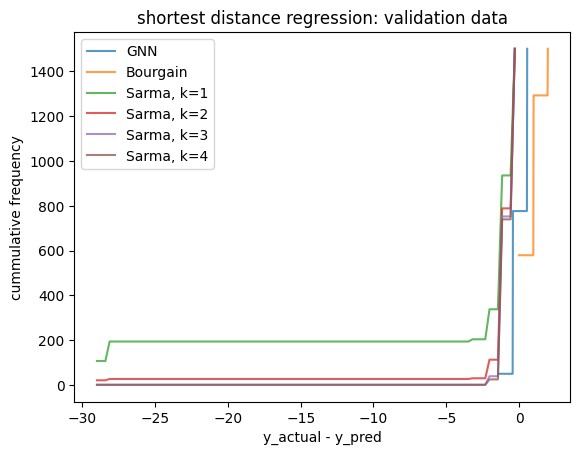

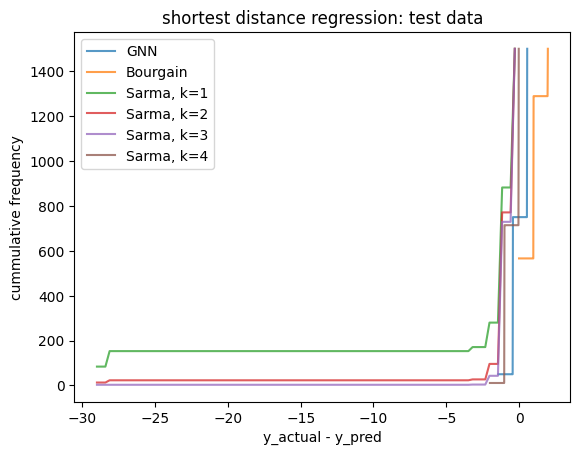

In [29]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,30,0.5)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2723, Validation Loss (MSE): 0.2723
Epoch: 020, Training Loss (MSE): 0.2715, Validation Loss (MSE): 0.2713
Epoch: 030, Training Loss (MSE): 0.2713, Validation Loss (MSE): 0.2710
Epoch: 040, Training Loss (MSE): 0.2712, Validation Loss (MSE): 0.2709
Epoch: 050, Training Loss (MSE): 0.2712, Validation Loss (MSE): 0.2710
Test Loss (MSE): 0.271087


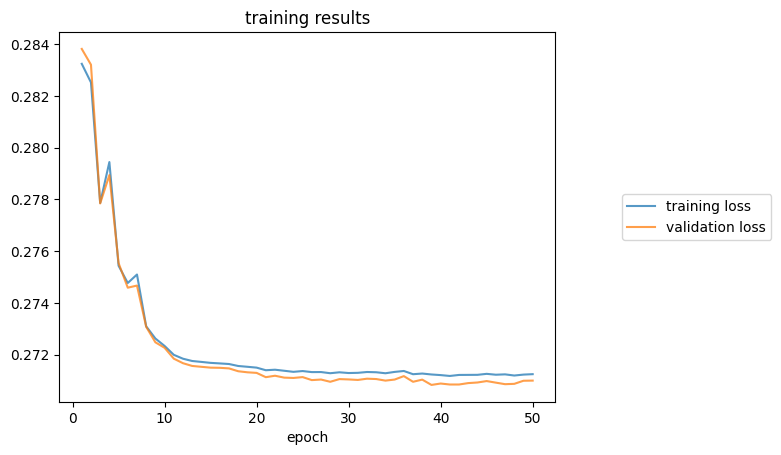

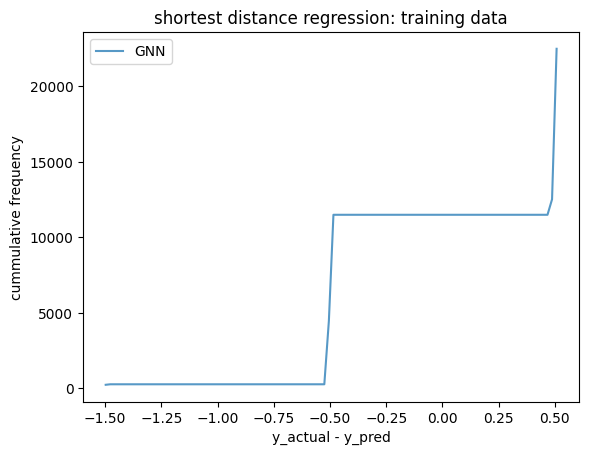

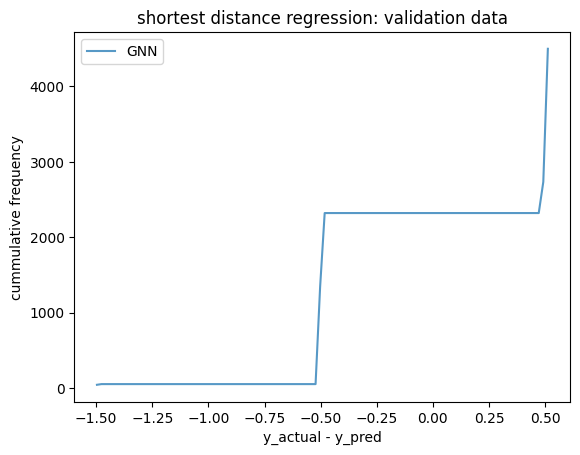

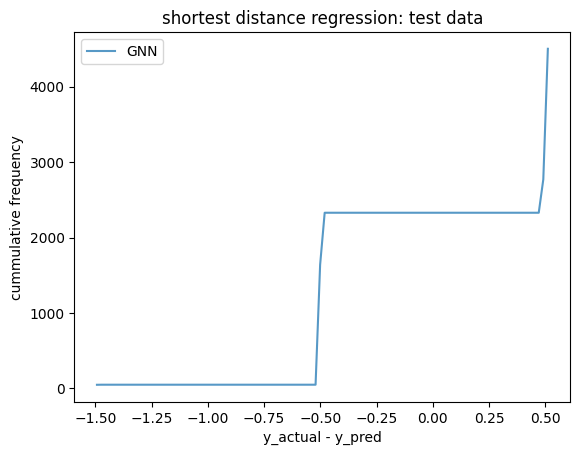

In [30]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,90,0.5)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2580, Validation Loss (MSE): 0.2581
Epoch: 020, Training Loss (MSE): 0.2574, Validation Loss (MSE): 0.2574
Epoch: 030, Training Loss (MSE): 0.2574, Validation Loss (MSE): 0.2574
Epoch: 040, Training Loss (MSE): 0.2574, Validation Loss (MSE): 0.2574
Epoch: 050, Training Loss (MSE): 0.2574, Validation Loss (MSE): 0.2574
Test Loss (MSE): 0.257449


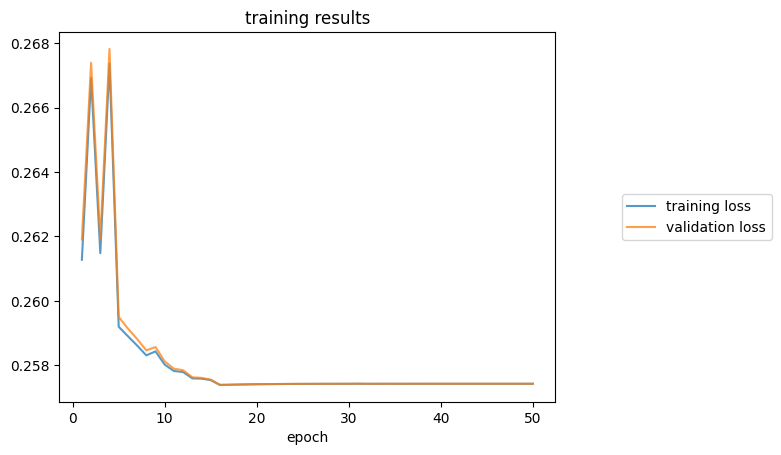

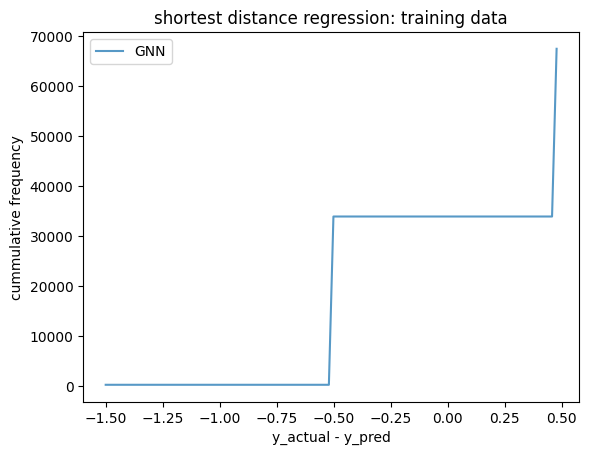

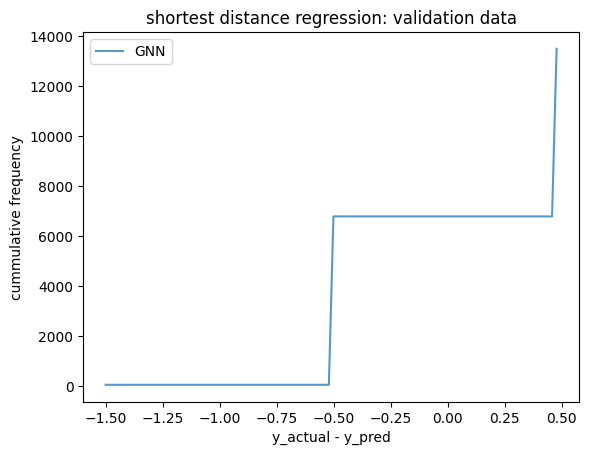

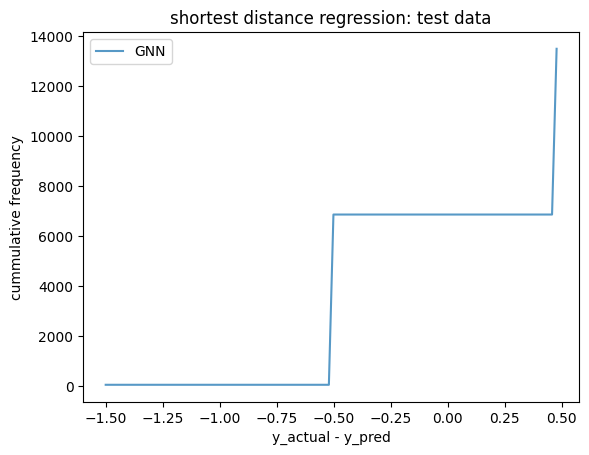

In [31]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,270,0.5)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2534, Validation Loss (MSE): 0.2535
Epoch: 020, Training Loss (MSE): 0.2536, Validation Loss (MSE): 0.2537
Epoch: 030, Training Loss (MSE): 0.2529, Validation Loss (MSE): 0.2529
Epoch: 040, Training Loss (MSE): 0.2529, Validation Loss (MSE): 0.2530
Epoch: 050, Training Loss (MSE): 0.2529, Validation Loss (MSE): 0.2530
Test Loss (MSE): 0.252821


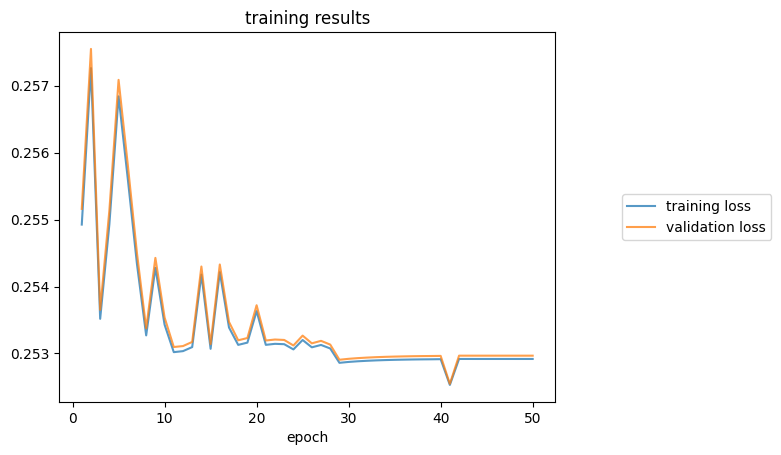

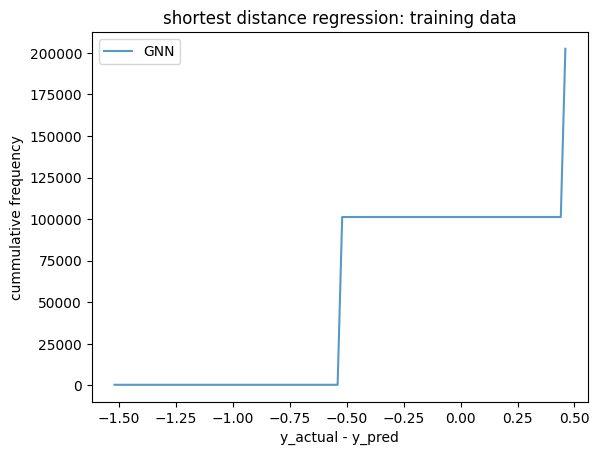

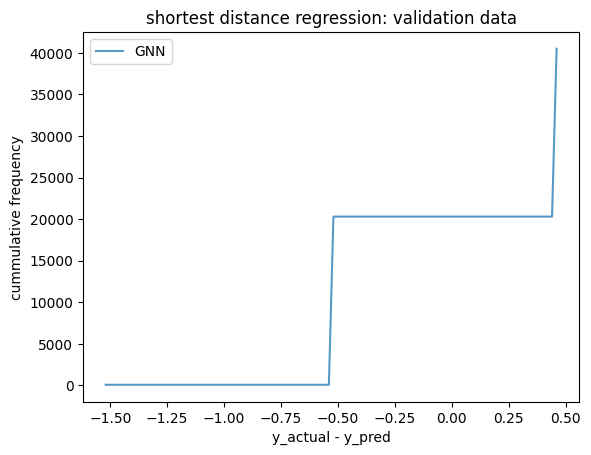

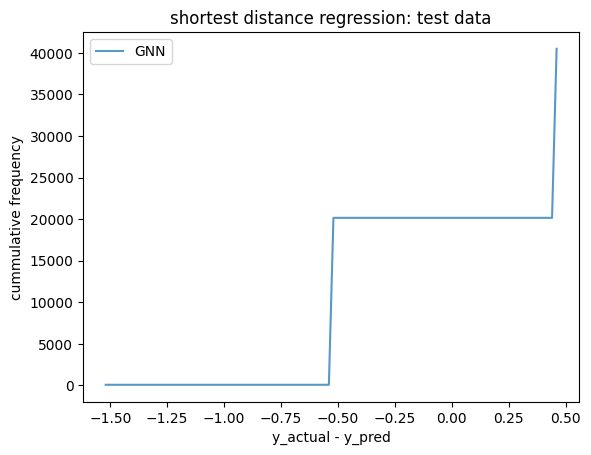

In [32]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,810,0.5)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2678, Validation Loss (MSE): 0.8382
Epoch: 020, Training Loss (MSE): 0.1988, Validation Loss (MSE): 0.6449
Epoch: 030, Training Loss (MSE): 0.2877, Validation Loss (MSE): 0.9407
Epoch: 040, Training Loss (MSE): 0.2184, Validation Loss (MSE): 0.8682
Epoch: 050, Training Loss (MSE): 0.2405, Validation Loss (MSE): 0.8509
Test Loss (MSE): 0.834621


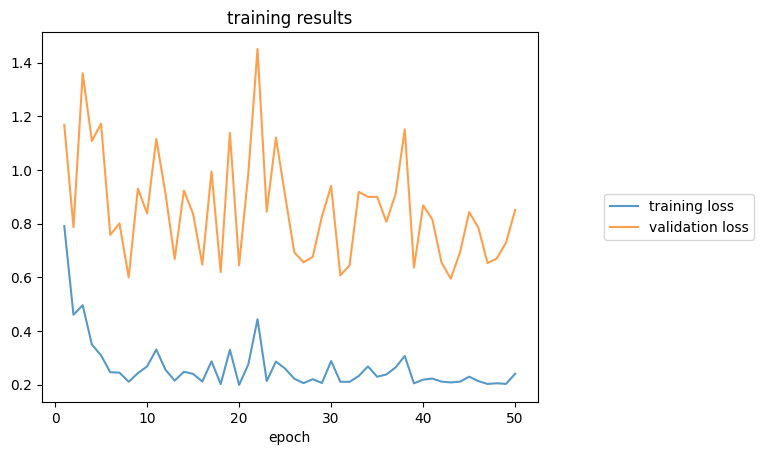

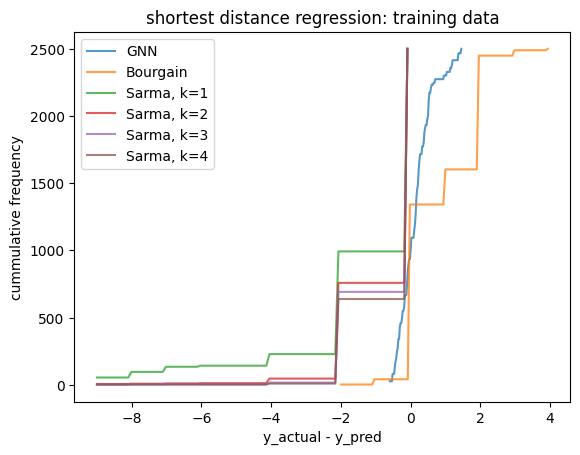

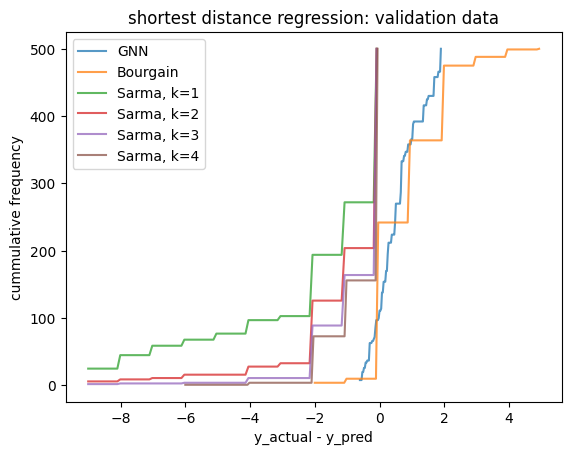

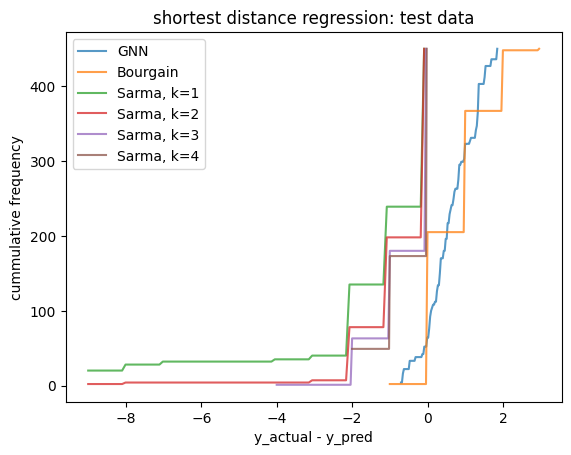

In [33]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,10,0.25)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.4310, Validation Loss (MSE): 0.4401
Epoch: 020, Training Loss (MSE): 0.4301, Validation Loss (MSE): 0.4385
Epoch: 030, Training Loss (MSE): 0.4304, Validation Loss (MSE): 0.4390
Epoch: 040, Training Loss (MSE): 0.4317, Validation Loss (MSE): 0.4404
Epoch: 050, Training Loss (MSE): 0.4310, Validation Loss (MSE): 0.4405
Test Loss (MSE): 0.515176


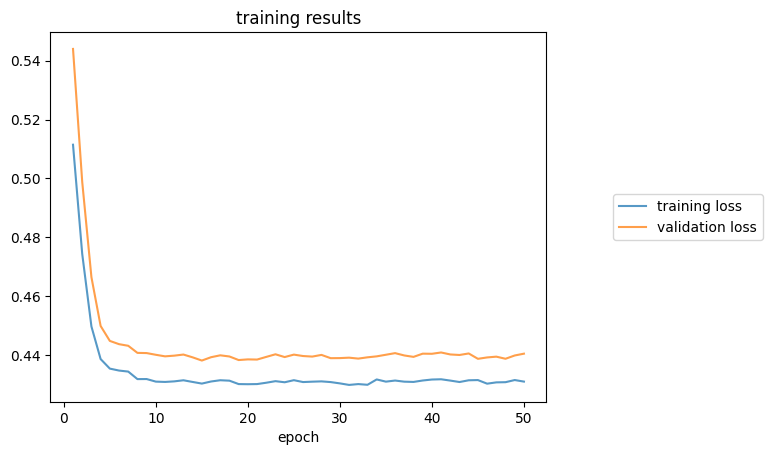

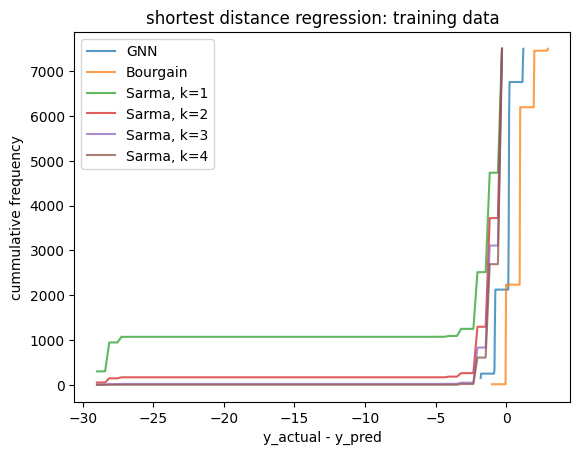

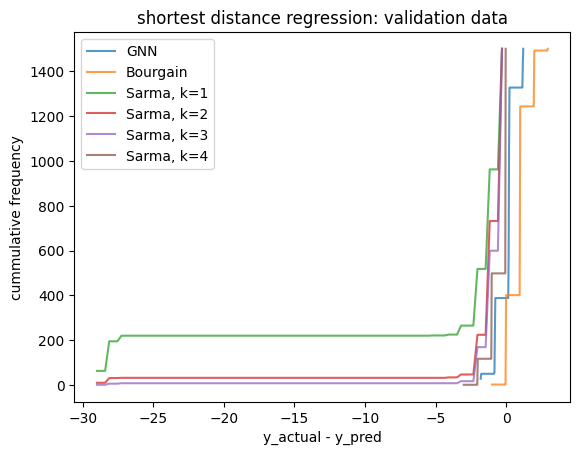

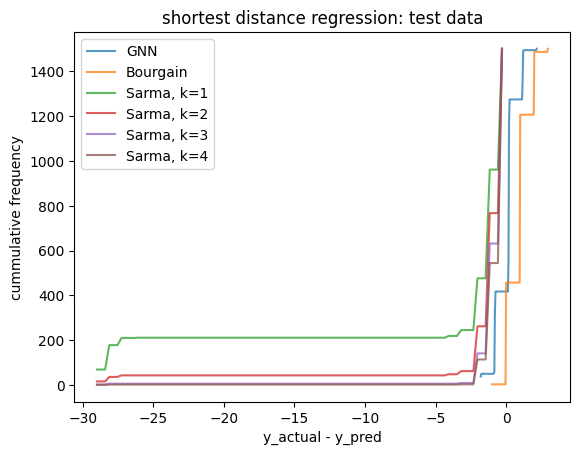

In [34]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,30,0.25)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2246, Validation Loss (MSE): 0.2280
Epoch: 020, Training Loss (MSE): 0.2253, Validation Loss (MSE): 0.2289
Epoch: 030, Training Loss (MSE): 0.2254, Validation Loss (MSE): 0.2290
Epoch: 040, Training Loss (MSE): 0.2254, Validation Loss (MSE): 0.2290
Epoch: 050, Training Loss (MSE): 0.2254, Validation Loss (MSE): 0.2290
Test Loss (MSE): 0.220554


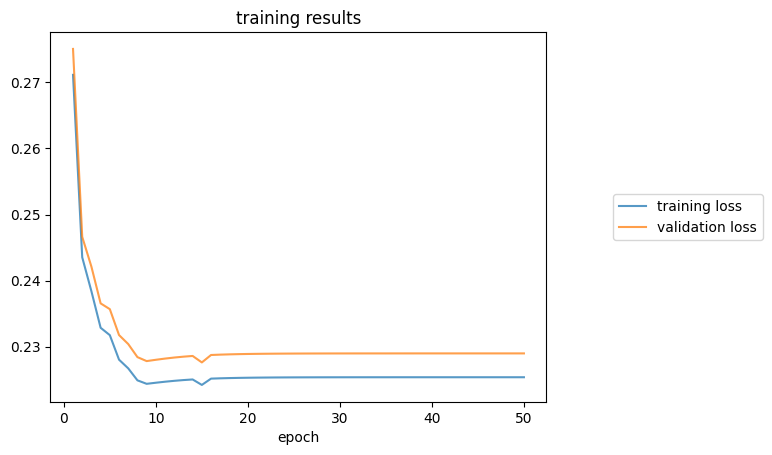

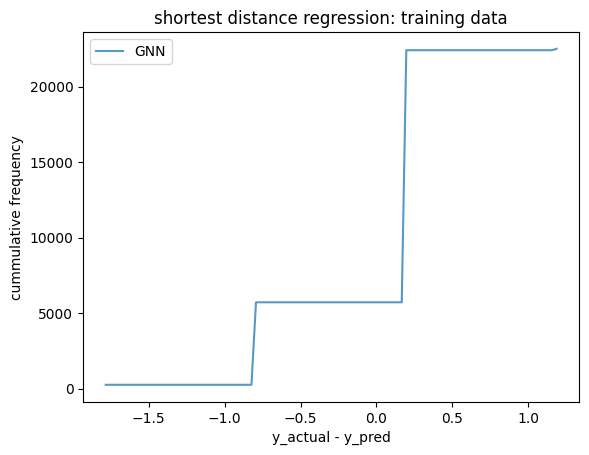

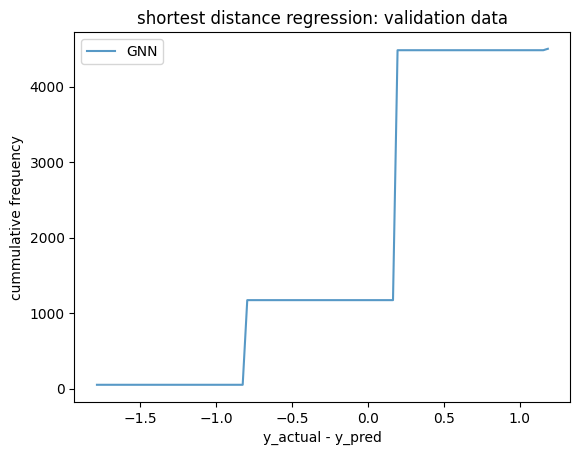

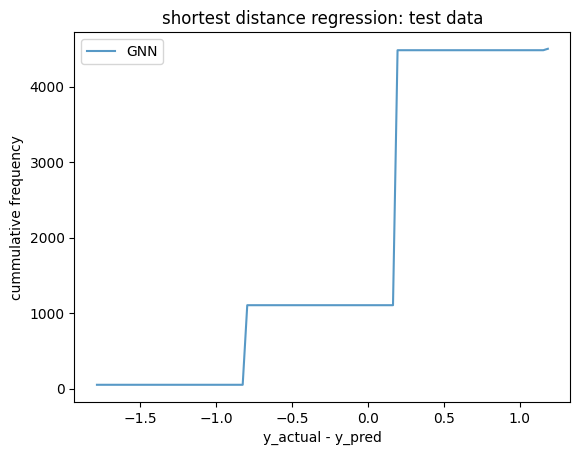

In [35]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,90,0.25)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1991, Validation Loss (MSE): 0.1961
Epoch: 020, Training Loss (MSE): 0.1987, Validation Loss (MSE): 0.1957
Epoch: 030, Training Loss (MSE): 0.1988, Validation Loss (MSE): 0.1957
Epoch: 040, Training Loss (MSE): 0.1988, Validation Loss (MSE): 0.1957
Epoch: 050, Training Loss (MSE): 0.1988, Validation Loss (MSE): 0.1957
Test Loss (MSE): 0.198095


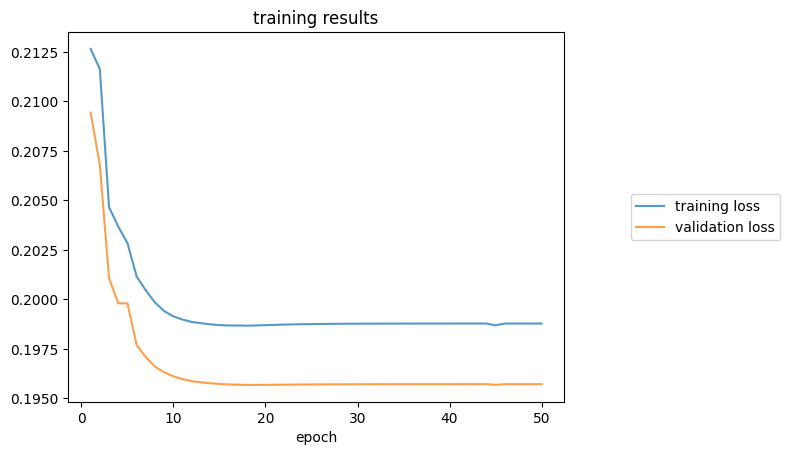

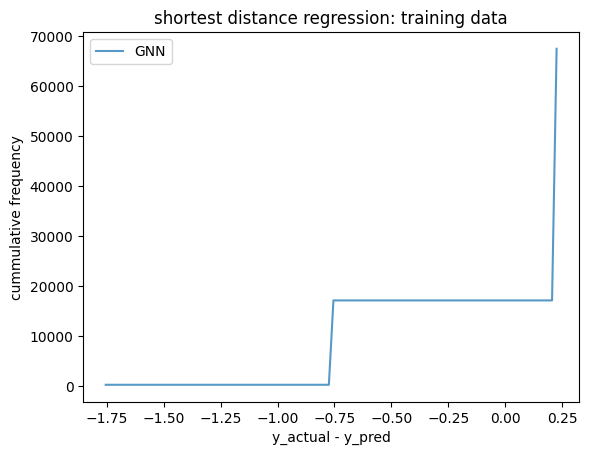

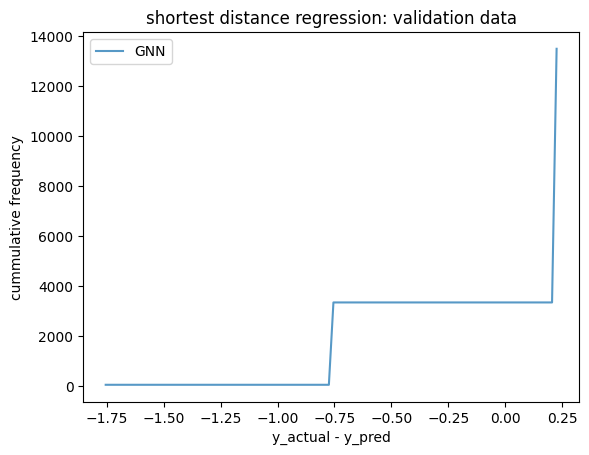

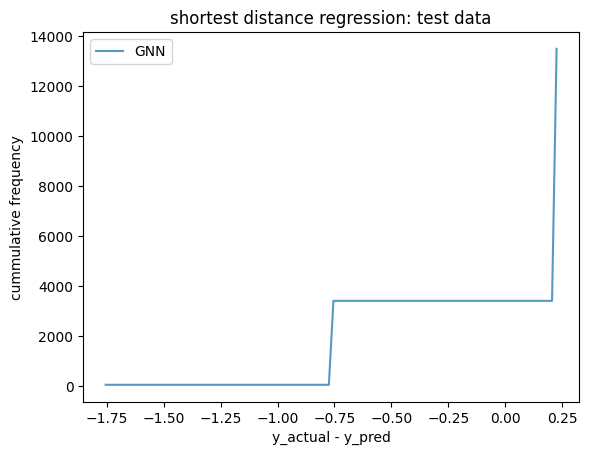

In [36]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,270,0.25)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1919, Validation Loss (MSE): 0.1927
Epoch: 020, Training Loss (MSE): 0.1909, Validation Loss (MSE): 0.1915
Epoch: 030, Training Loss (MSE): 0.1909, Validation Loss (MSE): 0.1915
Epoch: 040, Training Loss (MSE): 0.1909, Validation Loss (MSE): 0.1915
Epoch: 050, Training Loss (MSE): 0.1909, Validation Loss (MSE): 0.1915
Test Loss (MSE): 0.191287


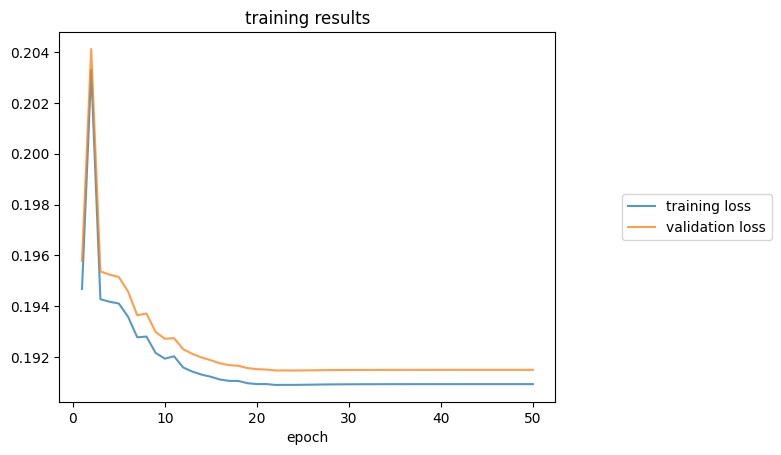

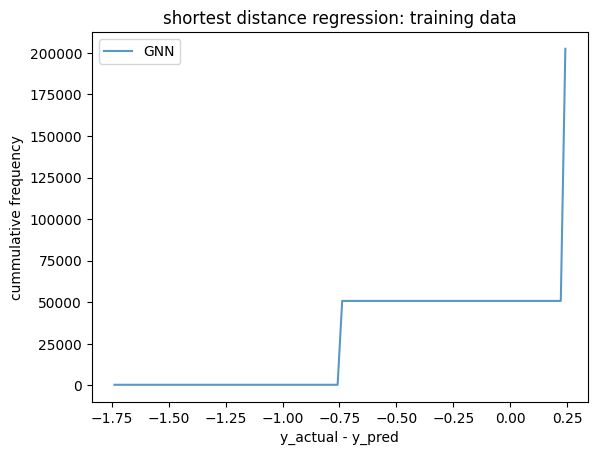

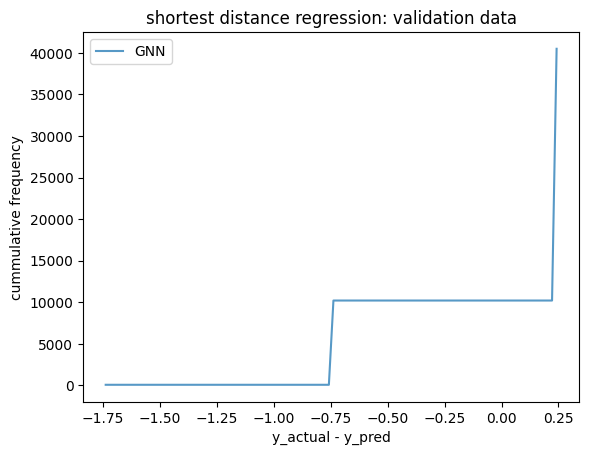

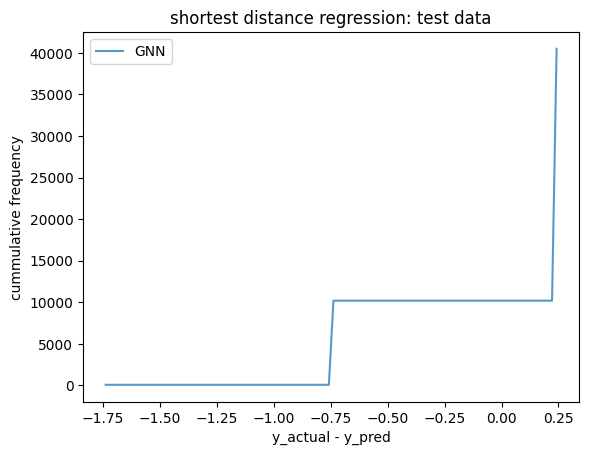

In [37]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,810,0.25)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1897, Validation Loss (MSE): 0.1892
Epoch: 020, Training Loss (MSE): 0.1892, Validation Loss (MSE): 0.1887
Epoch: 030, Training Loss (MSE): 0.1890, Validation Loss (MSE): 0.1886
Epoch: 040, Training Loss (MSE): 0.1890, Validation Loss (MSE): 0.1885
Epoch: 050, Training Loss (MSE): 0.1890, Validation Loss (MSE): 0.1885
Test Loss (MSE): 0.188665


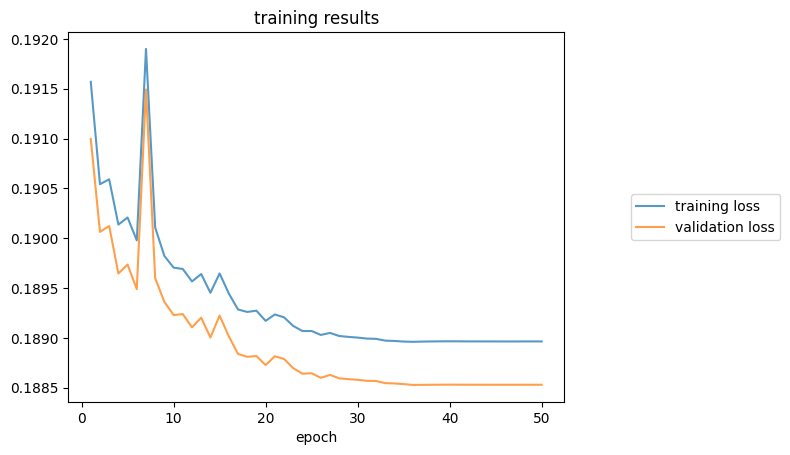

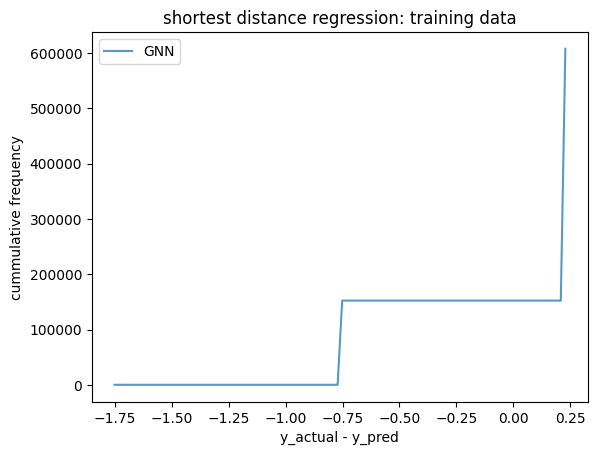

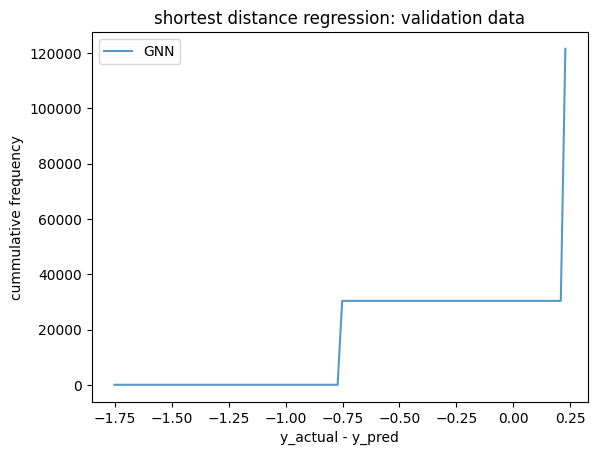

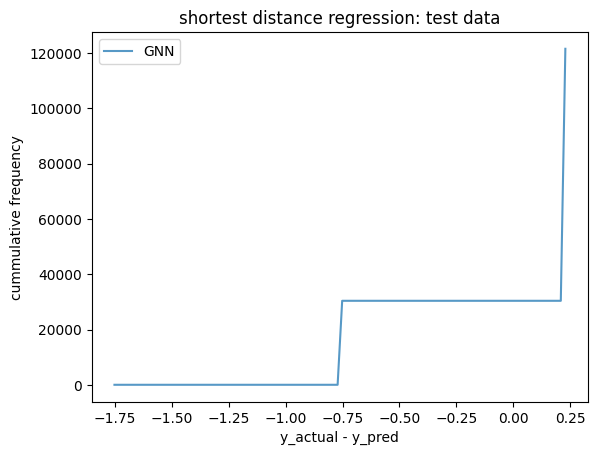

In [38]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,2430,0.25)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.7393, Validation Loss (MSE): 3.3391
Epoch: 020, Training Loss (MSE): 0.2628, Validation Loss (MSE): 3.7046
Epoch: 030, Training Loss (MSE): 0.2806, Validation Loss (MSE): 4.7712
Epoch: 040, Training Loss (MSE): 0.3983, Validation Loss (MSE): 3.6229
Epoch: 050, Training Loss (MSE): 0.2588, Validation Loss (MSE): 4.8029
Test Loss (MSE): 2.485567


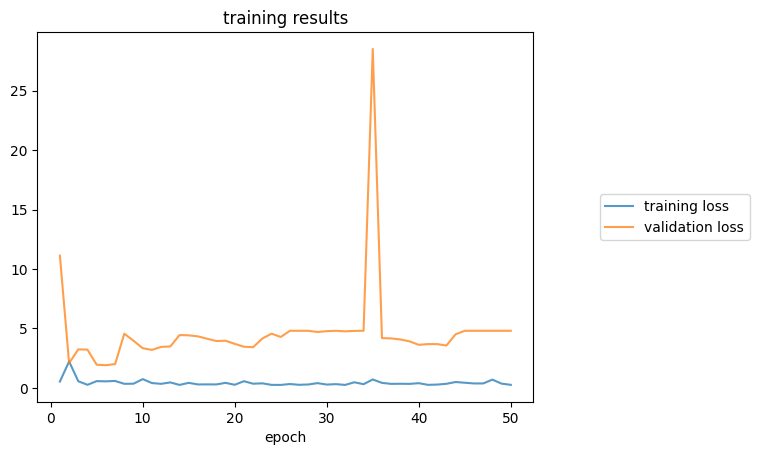

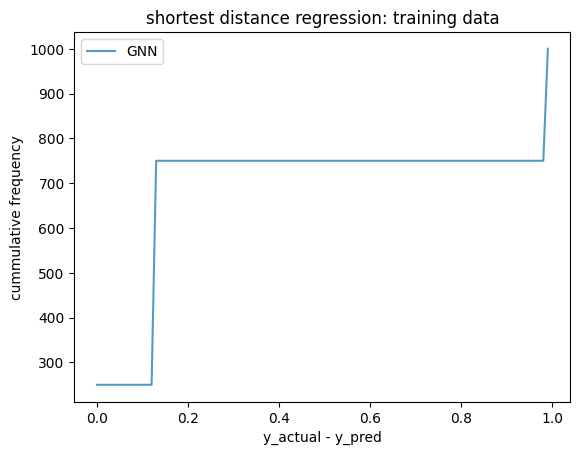

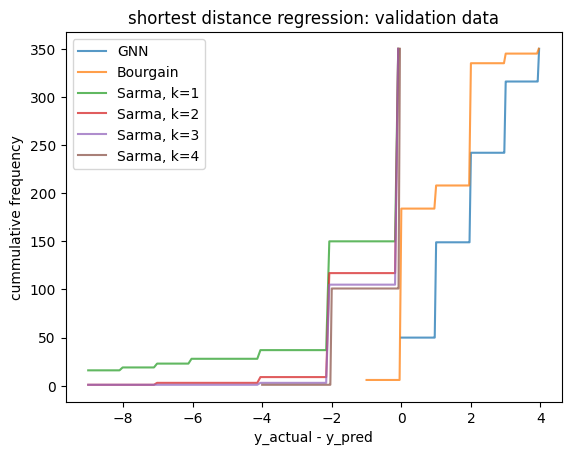

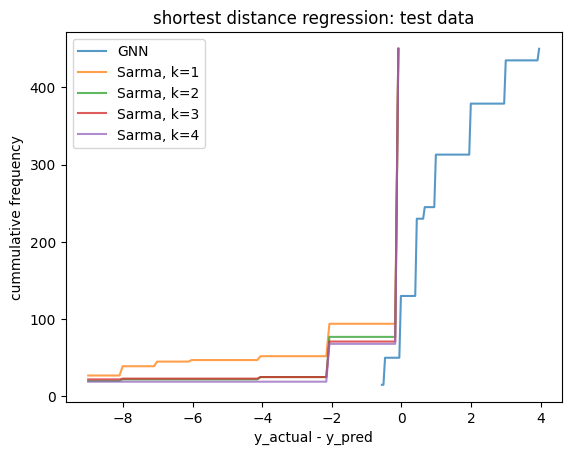

In [39]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,10,0.125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.4073, Validation Loss (MSE): 0.4117
Epoch: 020, Training Loss (MSE): 0.4053, Validation Loss (MSE): 0.4055
Epoch: 030, Training Loss (MSE): 0.4002, Validation Loss (MSE): 0.4015
Epoch: 040, Training Loss (MSE): 0.4092, Validation Loss (MSE): 0.4134
Epoch: 050, Training Loss (MSE): 0.2794, Validation Loss (MSE): 0.3242
Test Loss (MSE): 0.358920


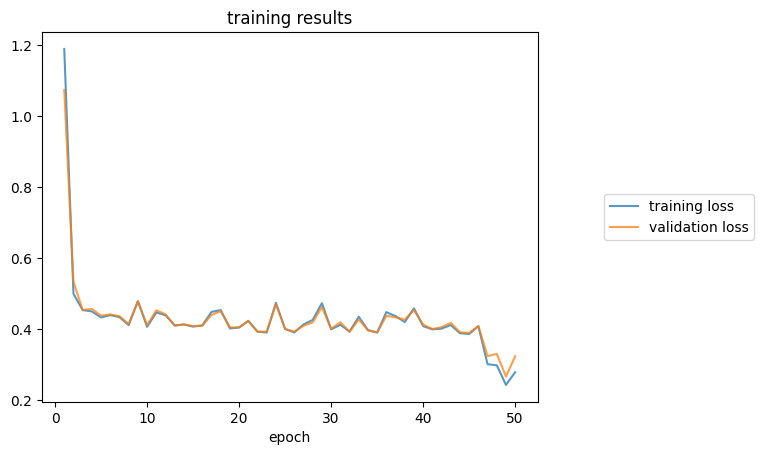

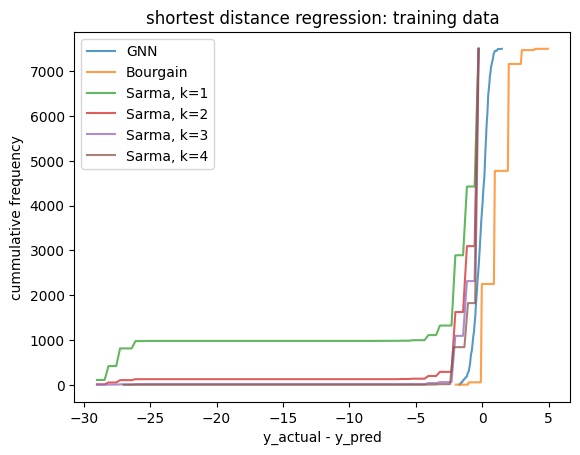

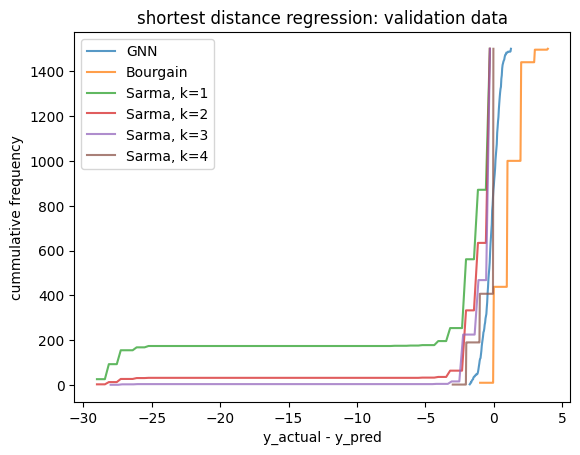

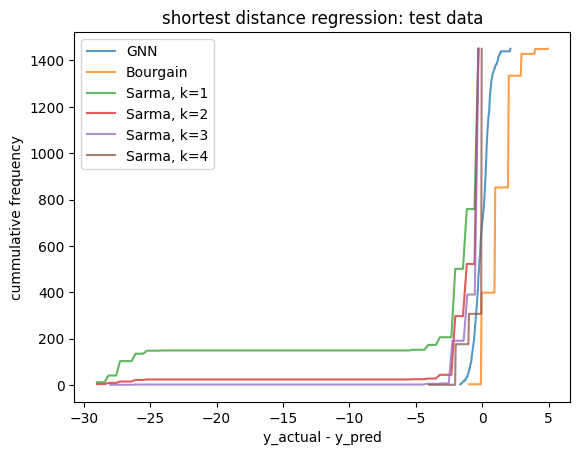

In [40]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,30,0.125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3736, Validation Loss (MSE): 0.3809
Epoch: 020, Training Loss (MSE): 0.3736, Validation Loss (MSE): 0.3810
Epoch: 030, Training Loss (MSE): 0.3736, Validation Loss (MSE): 0.3810
Epoch: 040, Training Loss (MSE): 0.3736, Validation Loss (MSE): 0.3810
Epoch: 050, Training Loss (MSE): 0.3736, Validation Loss (MSE): 0.3810
Test Loss (MSE): 0.359779


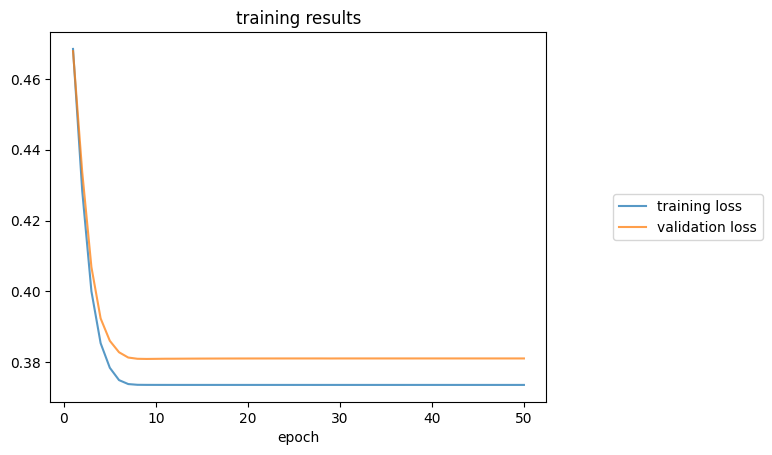

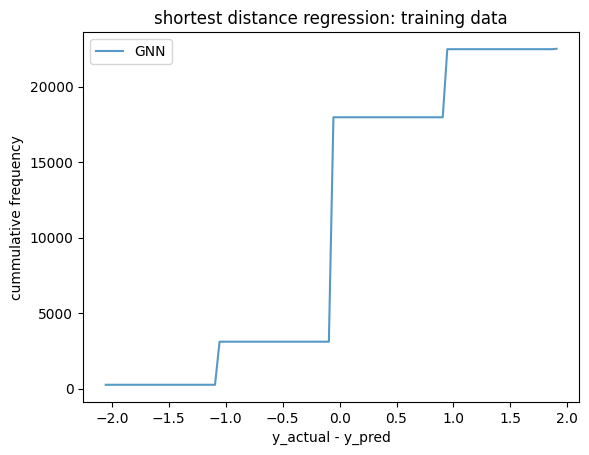

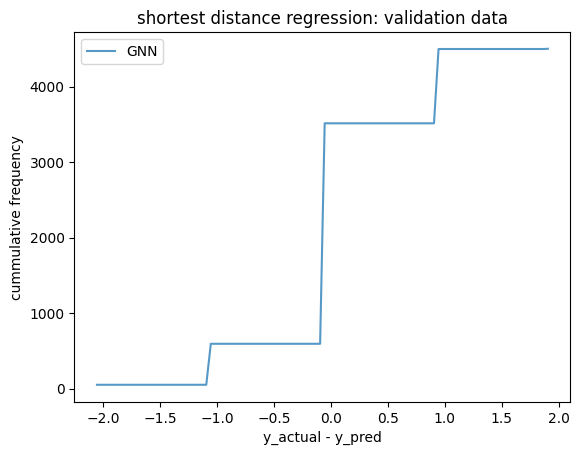

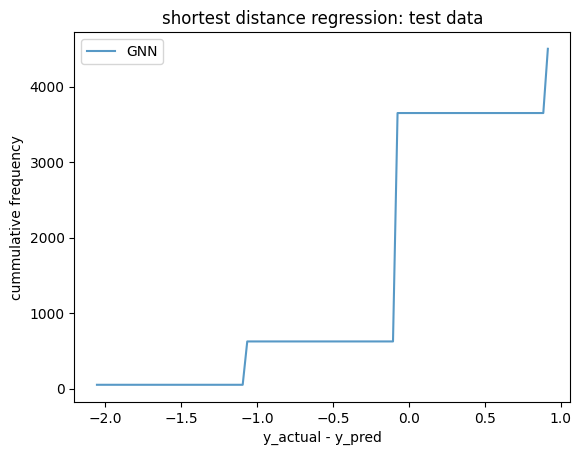

In [41]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,90,0.125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1380, Validation Loss (MSE): 0.1387
Epoch: 020, Training Loss (MSE): 0.1378, Validation Loss (MSE): 0.1384
Epoch: 030, Training Loss (MSE): 0.1377, Validation Loss (MSE): 0.1384
Epoch: 040, Training Loss (MSE): 0.1377, Validation Loss (MSE): 0.1384
Epoch: 050, Training Loss (MSE): 0.1377, Validation Loss (MSE): 0.1384
Test Loss (MSE): 0.139319


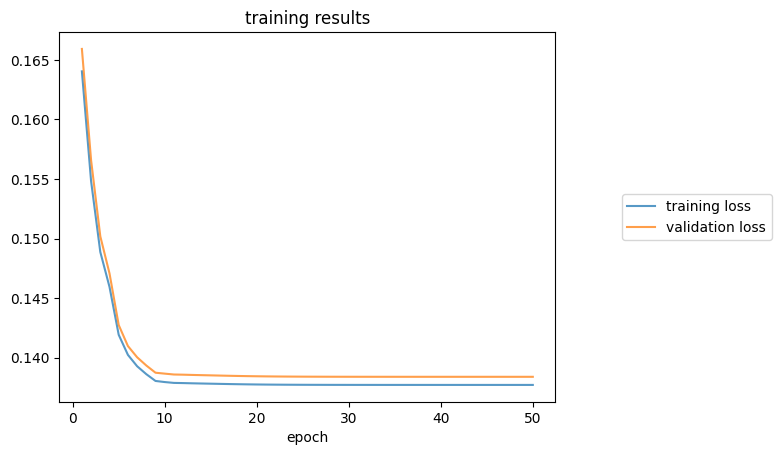

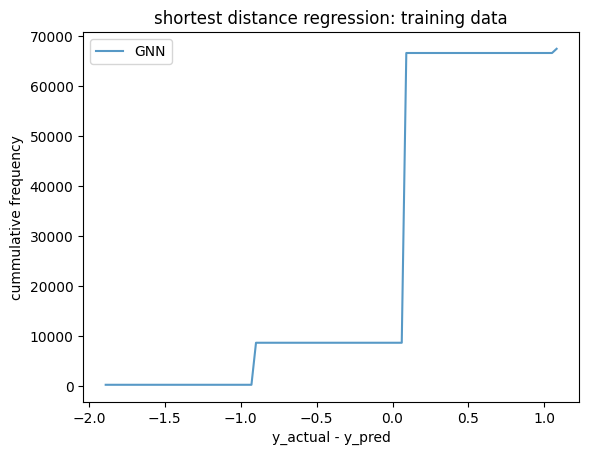

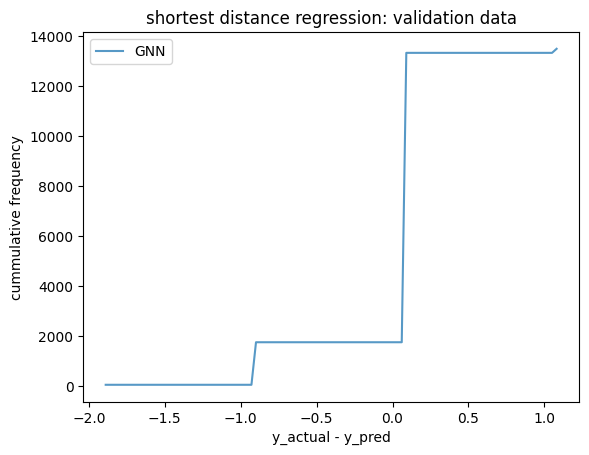

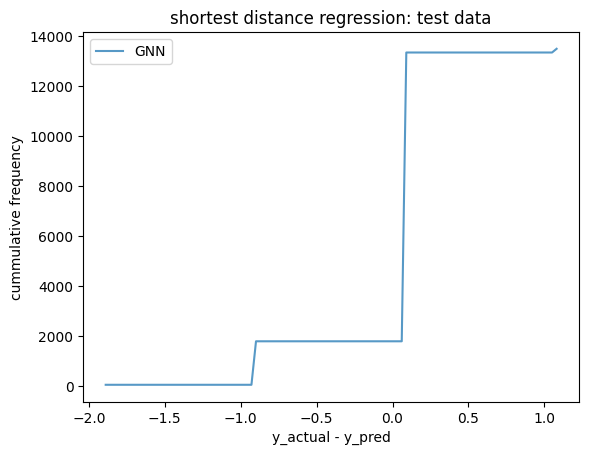

In [42]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,270,0.125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1137, Validation Loss (MSE): 0.1144
Epoch: 020, Training Loss (MSE): 0.1129, Validation Loss (MSE): 0.1136
Epoch: 030, Training Loss (MSE): 0.1129, Validation Loss (MSE): 0.1136
Epoch: 040, Training Loss (MSE): 0.1129, Validation Loss (MSE): 0.1136
Epoch: 050, Training Loss (MSE): 0.1129, Validation Loss (MSE): 0.1136
Test Loss (MSE): 0.111613


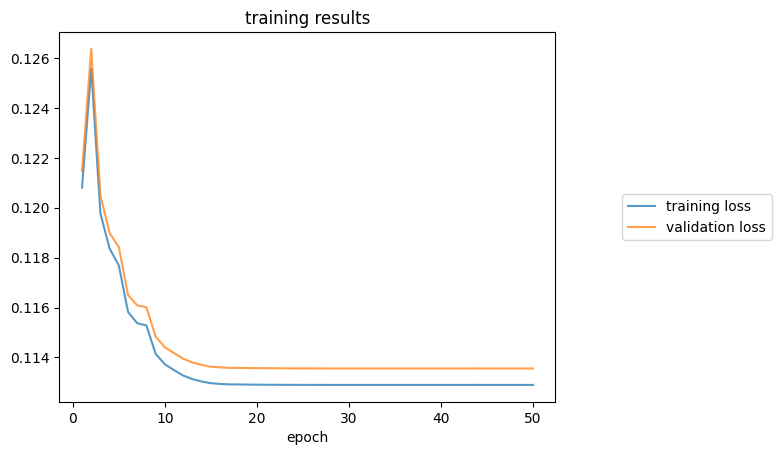

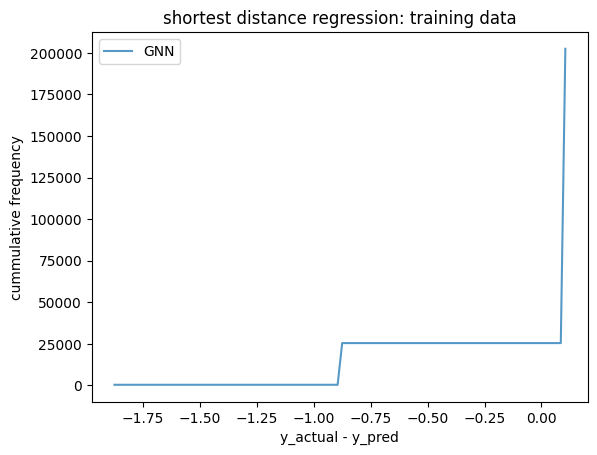

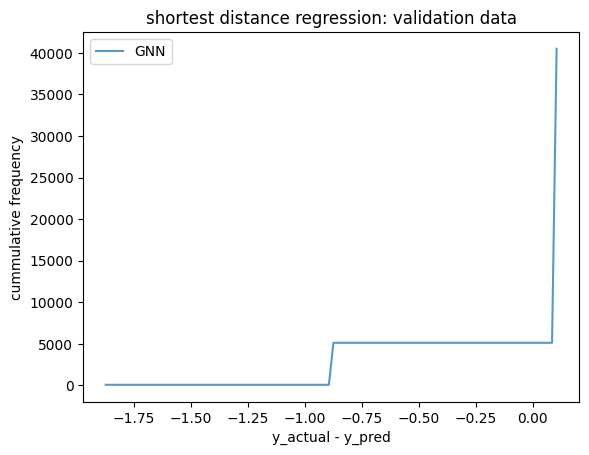

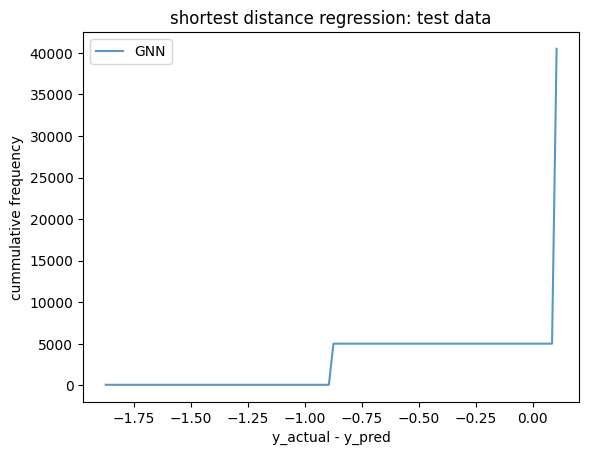

In [43]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,810,0.125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1111, Validation Loss (MSE): 0.1103
Epoch: 020, Training Loss (MSE): 0.1106, Validation Loss (MSE): 0.1097
Epoch: 030, Training Loss (MSE): 0.1106, Validation Loss (MSE): 0.1098
Epoch: 040, Training Loss (MSE): 0.1106, Validation Loss (MSE): 0.1098
Epoch: 050, Training Loss (MSE): 0.1106, Validation Loss (MSE): 0.1098
Test Loss (MSE): 0.111226


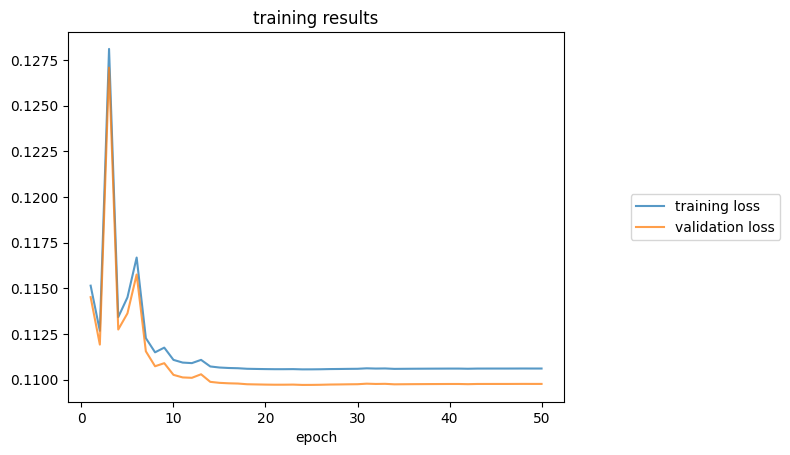

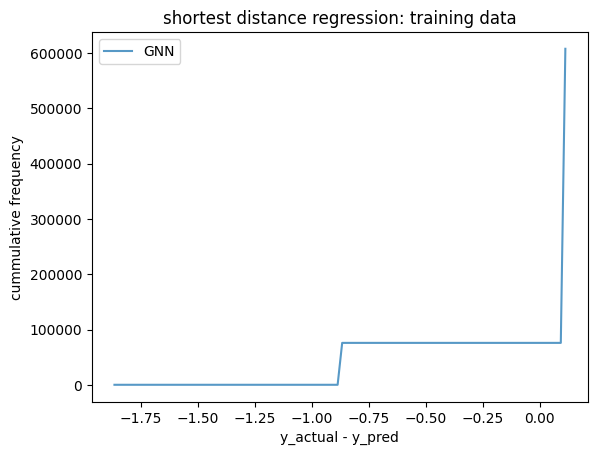

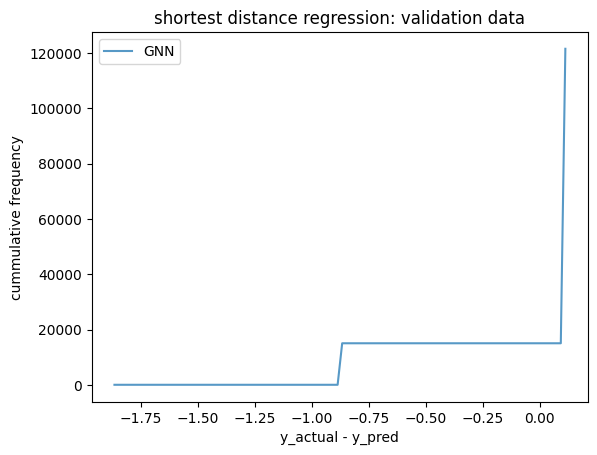

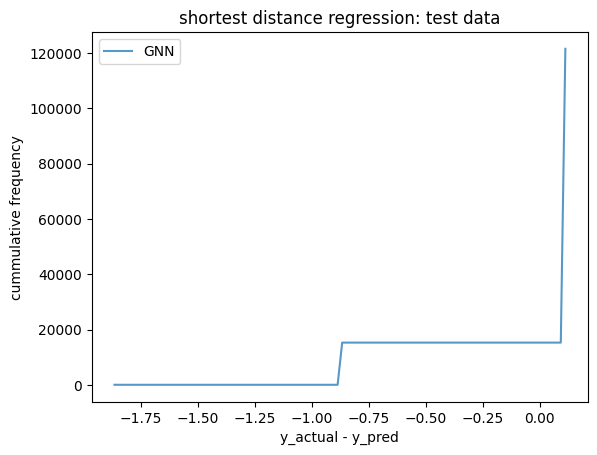

In [44]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,2430,0.125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.8132, Validation Loss (MSE): 0.7234
Epoch: 020, Training Loss (MSE): 0.8865, Validation Loss (MSE): 0.8118
Epoch: 030, Training Loss (MSE): 0.8865, Validation Loss (MSE): 0.8124
Epoch: 040, Training Loss (MSE): 0.8865, Validation Loss (MSE): 0.8126
Epoch: 050, Training Loss (MSE): 0.8865, Validation Loss (MSE): 0.8127
Test Loss (MSE): 0.558518


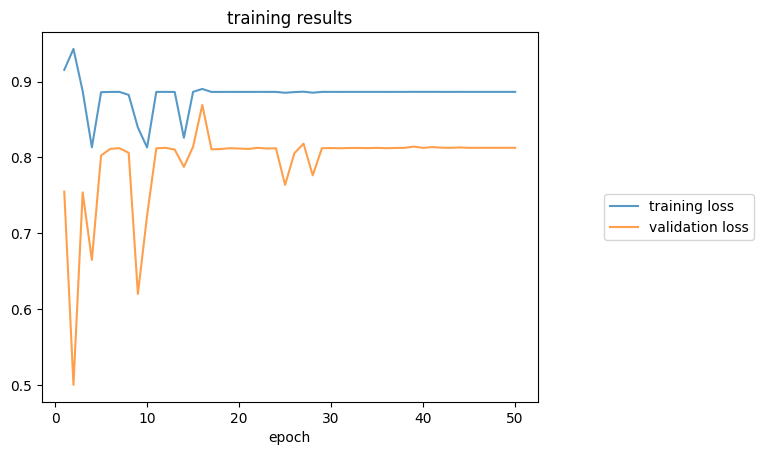

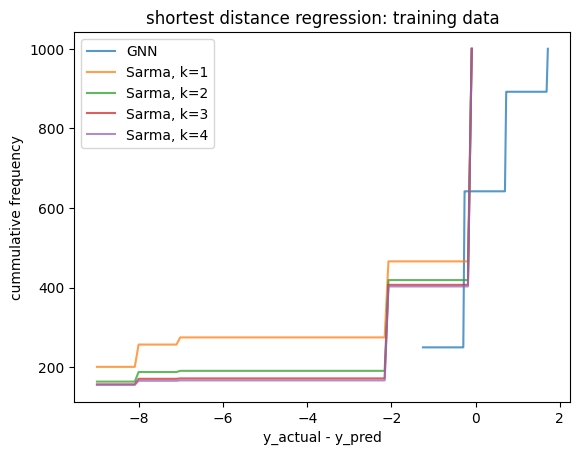

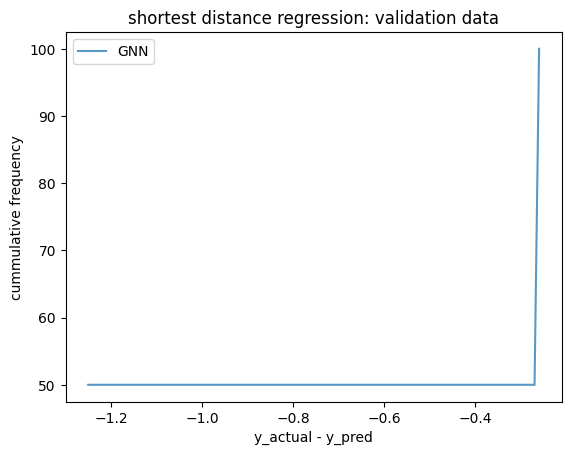

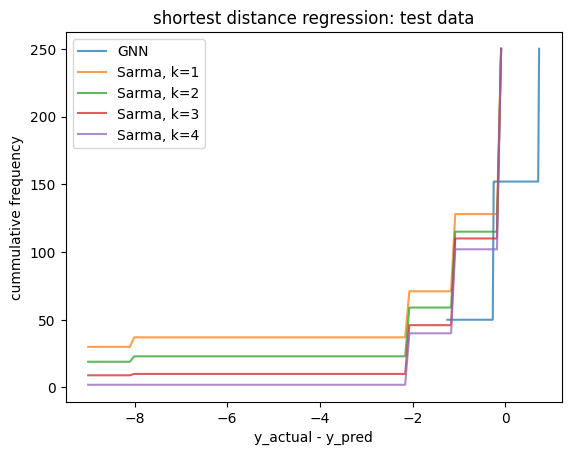

In [45]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,10,0.0625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 18.4763, Validation Loss (MSE): 59.8192
Epoch: 020, Training Loss (MSE): 14.2572, Validation Loss (MSE): 73.6062
Epoch: 030, Training Loss (MSE): 13.9341, Validation Loss (MSE): 71.4249
Epoch: 040, Training Loss (MSE): 13.5586, Validation Loss (MSE): 73.1895
Epoch: 050, Training Loss (MSE): 13.3594, Validation Loss (MSE): 74.9850
Test Loss (MSE): 75.078842


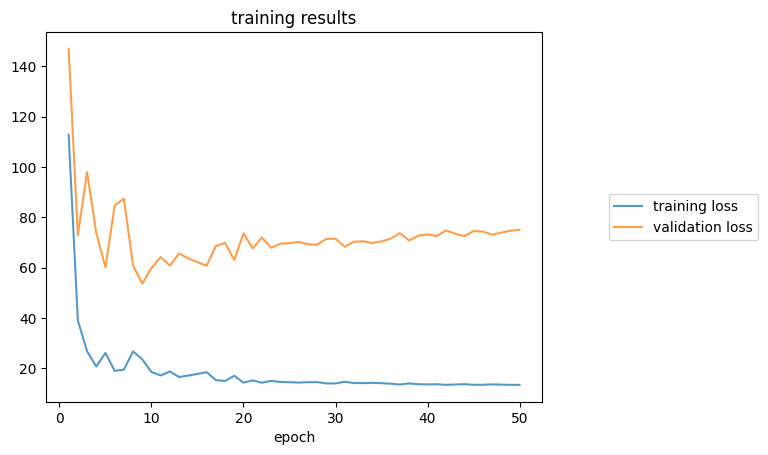

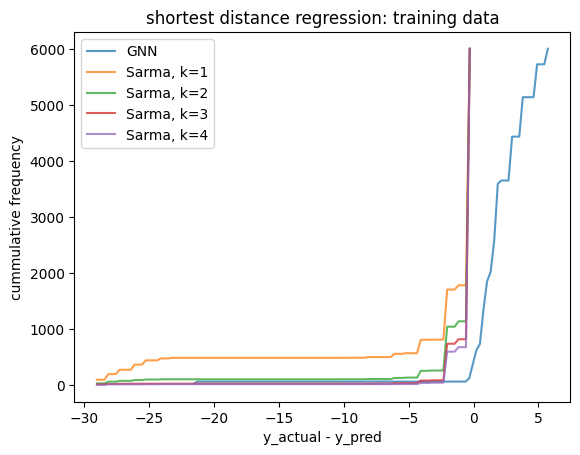

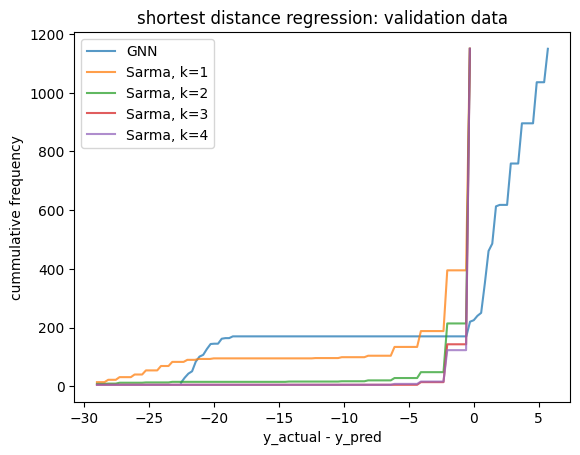

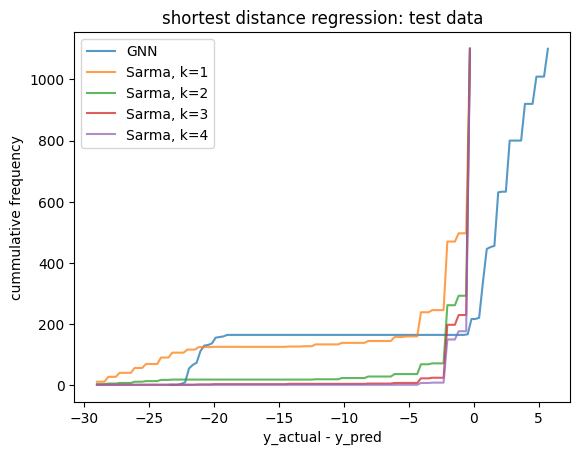

In [46]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,30,0.0625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.4148, Validation Loss (MSE): 0.4239
Epoch: 020, Training Loss (MSE): 0.3711, Validation Loss (MSE): 0.3825
Epoch: 030, Training Loss (MSE): 0.3351, Validation Loss (MSE): 0.3534
Epoch: 040, Training Loss (MSE): 0.3507, Validation Loss (MSE): 0.3473
Epoch: 050, Training Loss (MSE): 0.1916, Validation Loss (MSE): 0.1987
Test Loss (MSE): 0.179738


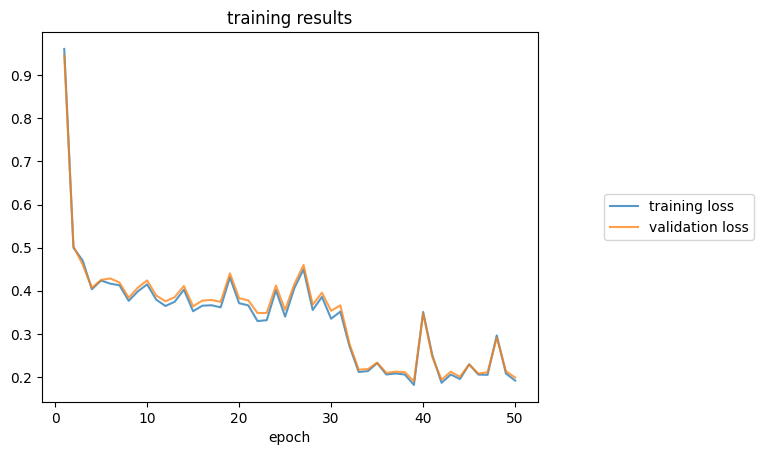

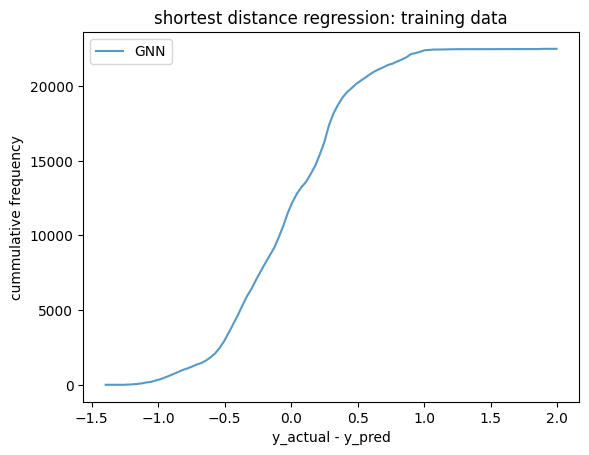

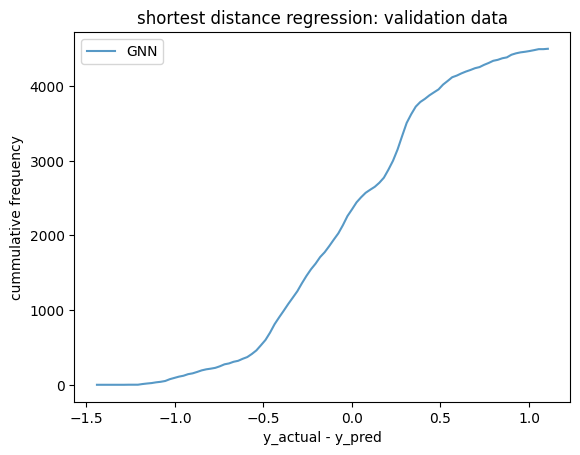

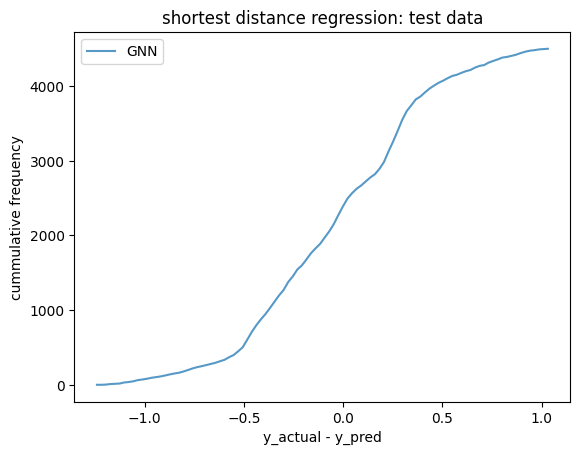

In [47]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,90,0.0625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3399, Validation Loss (MSE): 0.3353
Epoch: 020, Training Loss (MSE): 0.3399, Validation Loss (MSE): 0.3353
Epoch: 030, Training Loss (MSE): 0.3399, Validation Loss (MSE): 0.3353
Epoch: 040, Training Loss (MSE): 0.3399, Validation Loss (MSE): 0.3353
Epoch: 050, Training Loss (MSE): 0.3399, Validation Loss (MSE): 0.3353
Test Loss (MSE): 0.337950


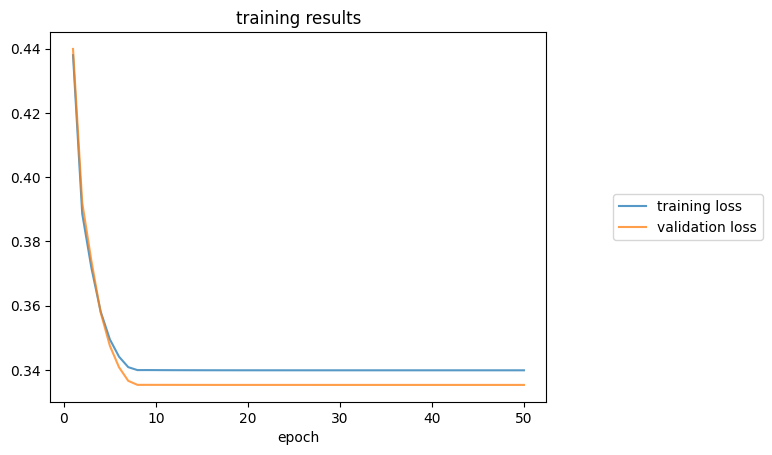

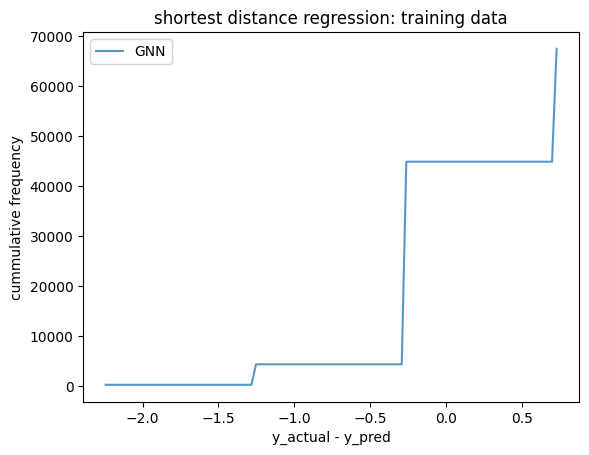

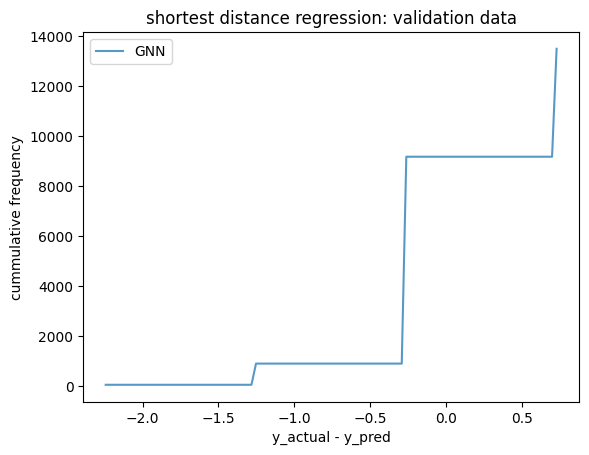

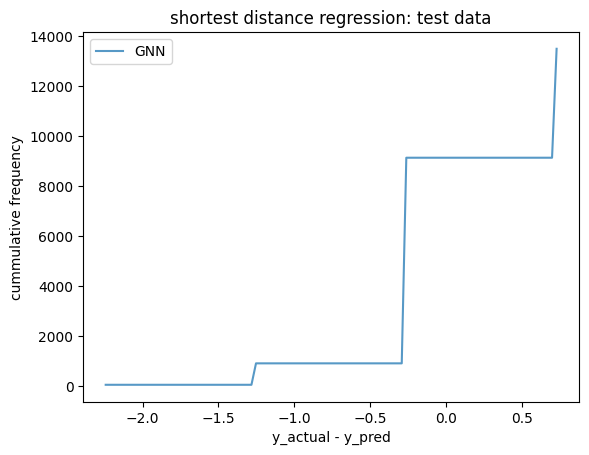

In [48]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,270,0.0625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1057, Validation Loss (MSE): 0.1086
Epoch: 020, Training Loss (MSE): 0.1048, Validation Loss (MSE): 0.1075
Epoch: 030, Training Loss (MSE): 0.1048, Validation Loss (MSE): 0.1076
Epoch: 040, Training Loss (MSE): 0.1048, Validation Loss (MSE): 0.1076
Epoch: 050, Training Loss (MSE): 0.1048, Validation Loss (MSE): 0.1076
Test Loss (MSE): 0.104888


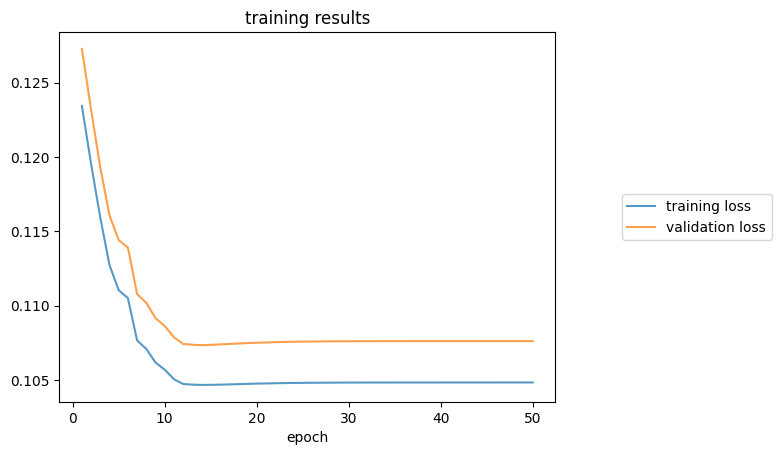

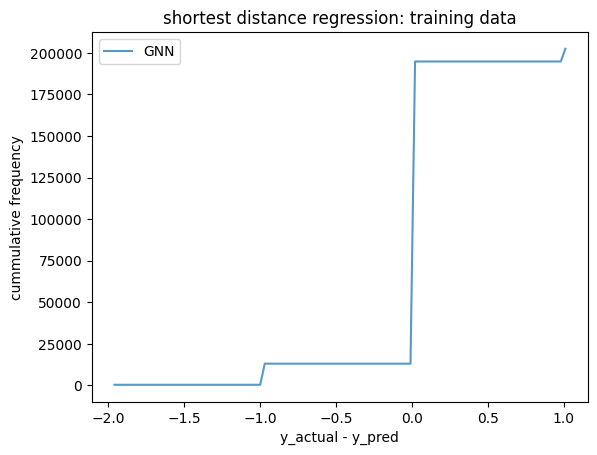

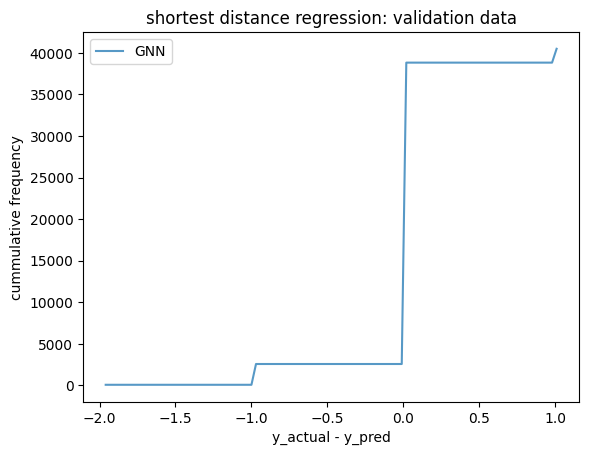

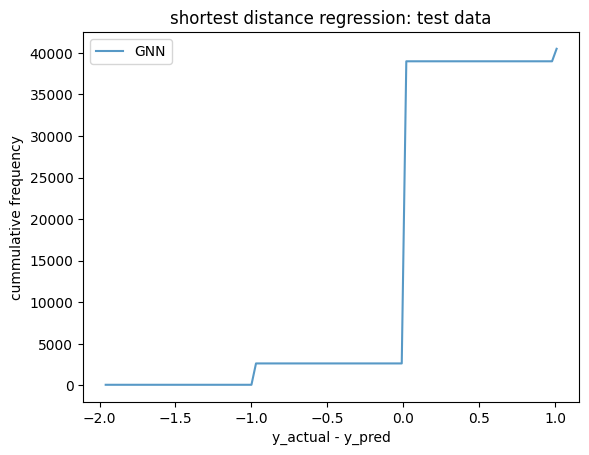

In [49]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,810,0.0625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.0611, Validation Loss (MSE): 0.0613
Epoch: 020, Training Loss (MSE): 0.0604, Validation Loss (MSE): 0.0606
Epoch: 030, Training Loss (MSE): 0.0604, Validation Loss (MSE): 0.0606
Epoch: 040, Training Loss (MSE): 0.0604, Validation Loss (MSE): 0.0606
Epoch: 050, Training Loss (MSE): 0.0604, Validation Loss (MSE): 0.0606
Test Loss (MSE): 0.060957


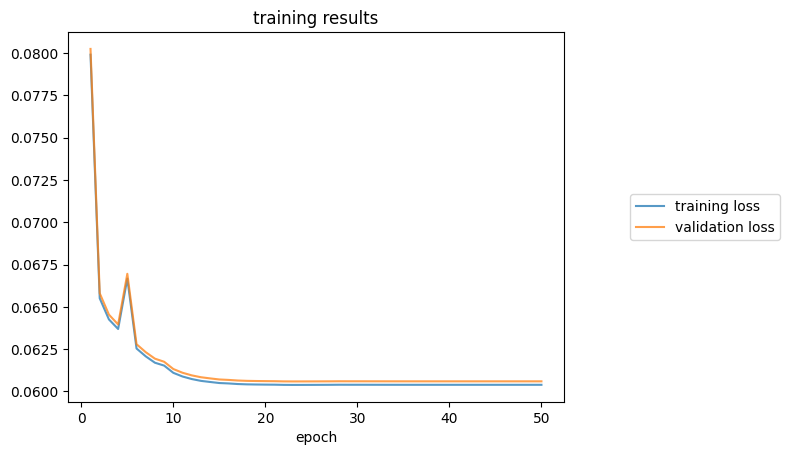

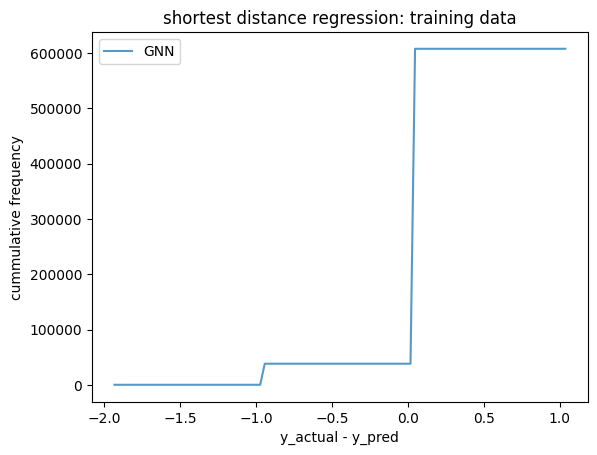

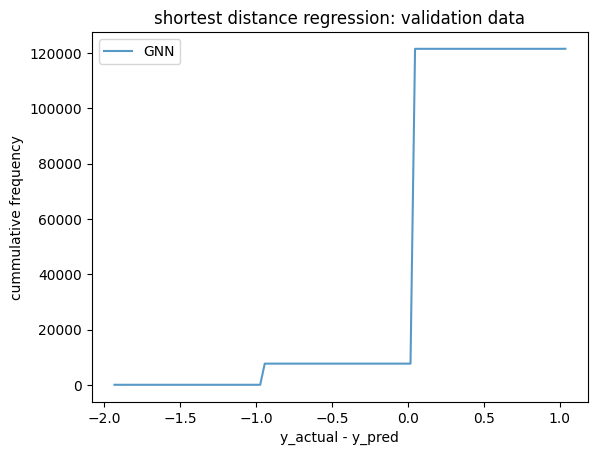

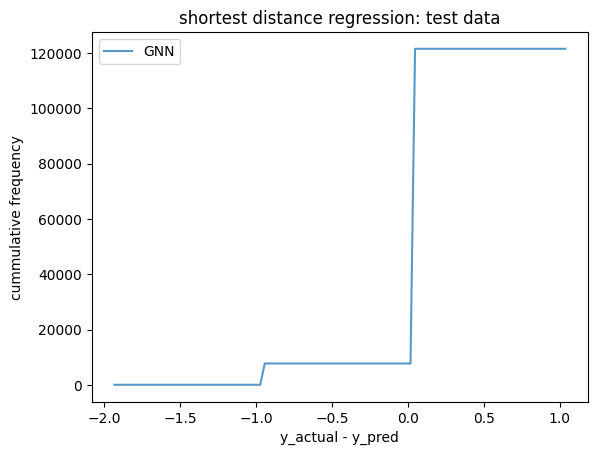

In [51]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,2430,0.0625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Epoch: 020, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Epoch: 030, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Epoch: 040, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Epoch: 050, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Test Loss (MSE): 45.241669


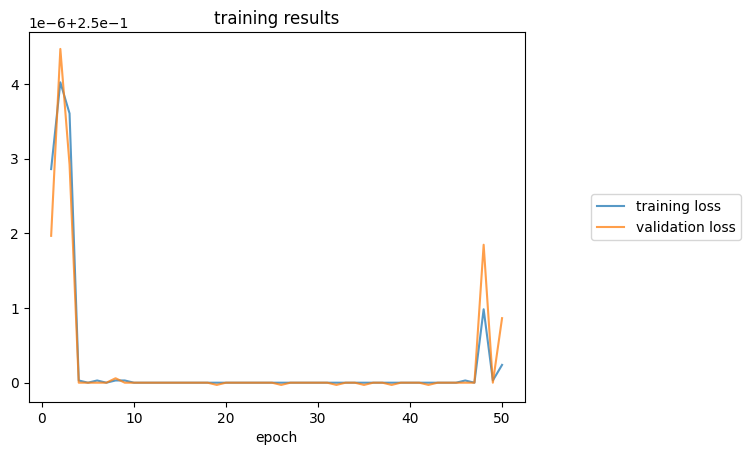

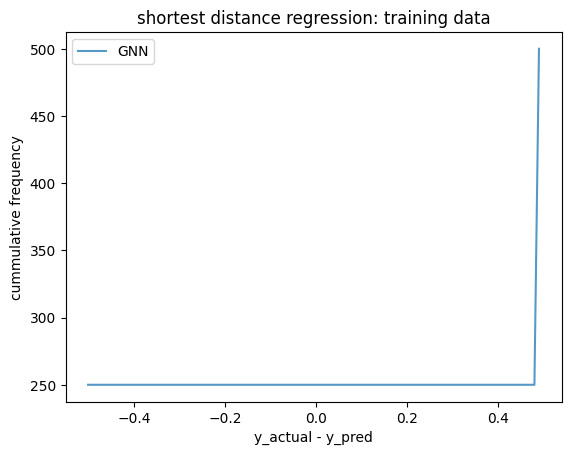

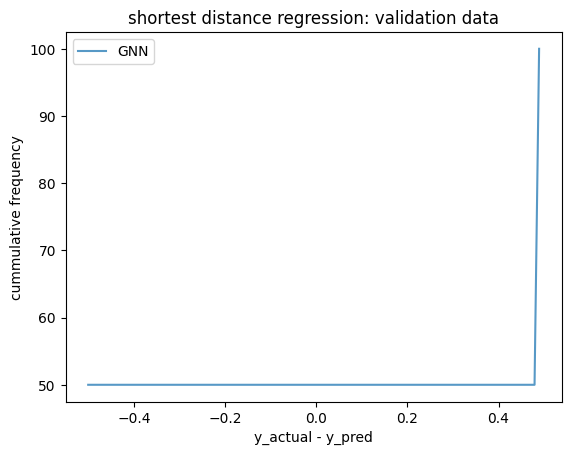

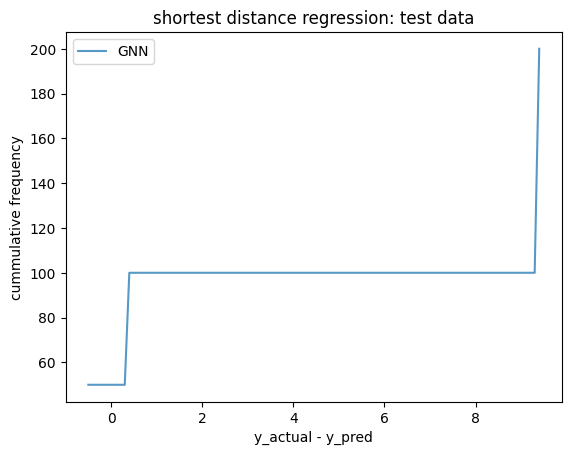

In [52]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,10,0.03125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 14.4479, Validation Loss (MSE): 15.8092
Epoch: 020, Training Loss (MSE): 2.6219, Validation Loss (MSE): 5.2102
Epoch: 030, Training Loss (MSE): 1.4660, Validation Loss (MSE): 4.3908
Epoch: 040, Training Loss (MSE): 1.4327, Validation Loss (MSE): 4.4068
Epoch: 050, Training Loss (MSE): 1.4277, Validation Loss (MSE): 4.4122
Test Loss (MSE): 1.659327


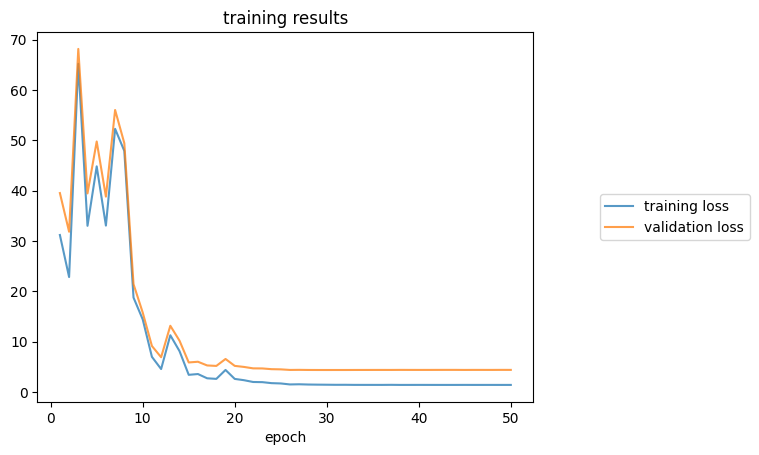

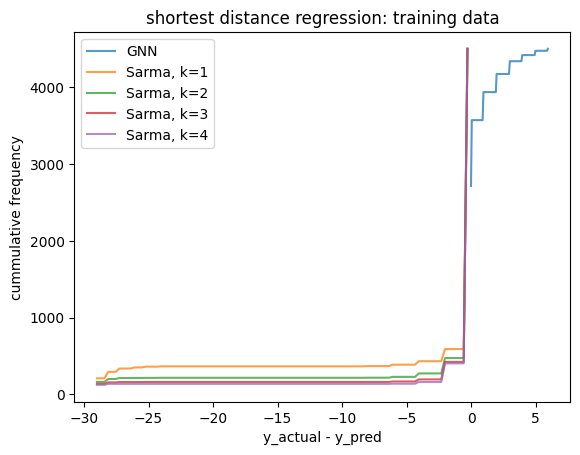

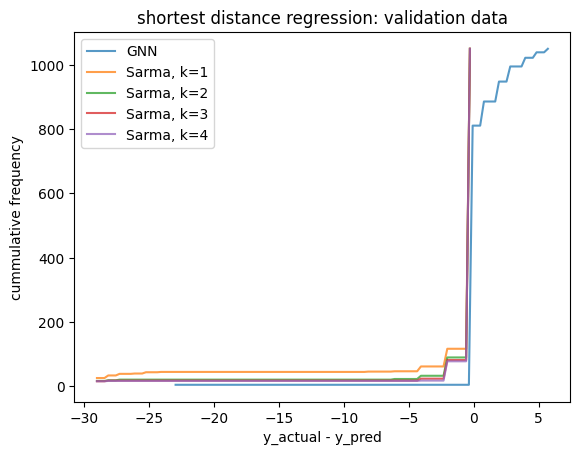

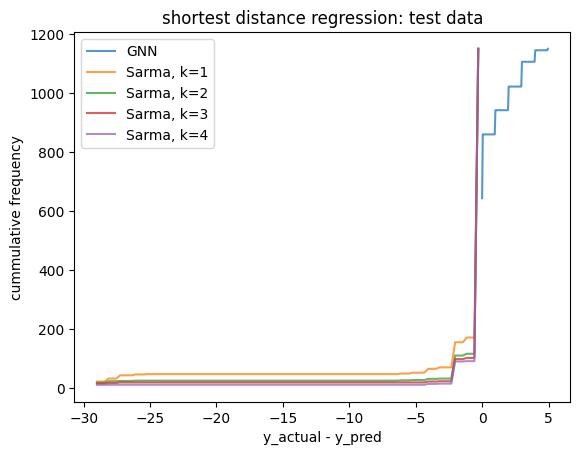

In [53]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,30,0.03125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 279.8655, Validation Loss (MSE): 3.3049
Epoch: 020, Training Loss (MSE): 280.7526, Validation Loss (MSE): 3.3387
Epoch: 030, Training Loss (MSE): 321.9876, Validation Loss (MSE): 18.0470
Epoch: 040, Training Loss (MSE): 320.4034, Validation Loss (MSE): 26.8586
Epoch: 050, Training Loss (MSE): 320.4039, Validation Loss (MSE): 26.8506
Test Loss (MSE): 25.992767


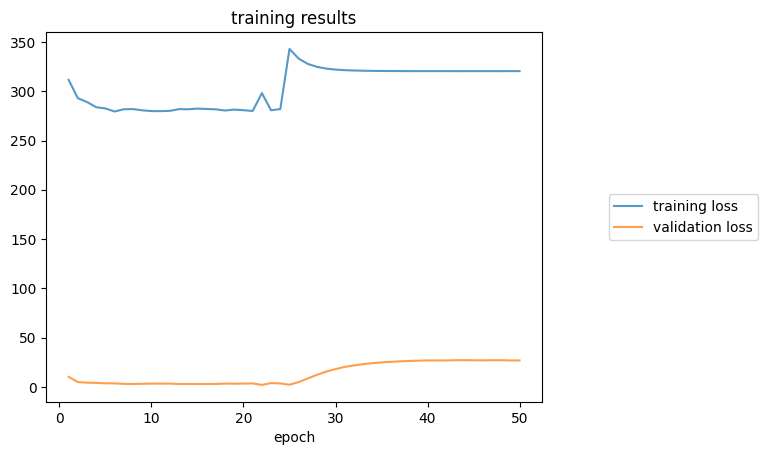

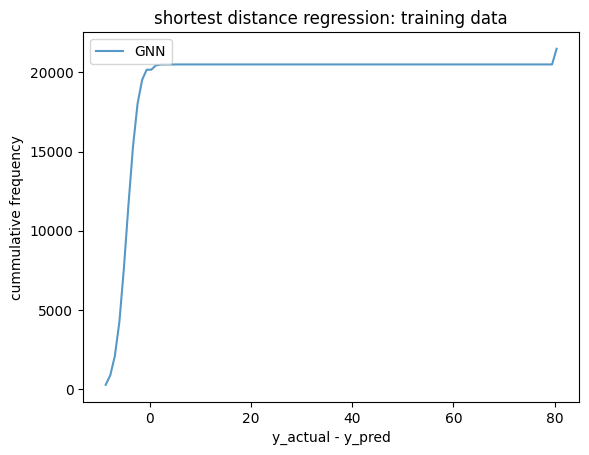

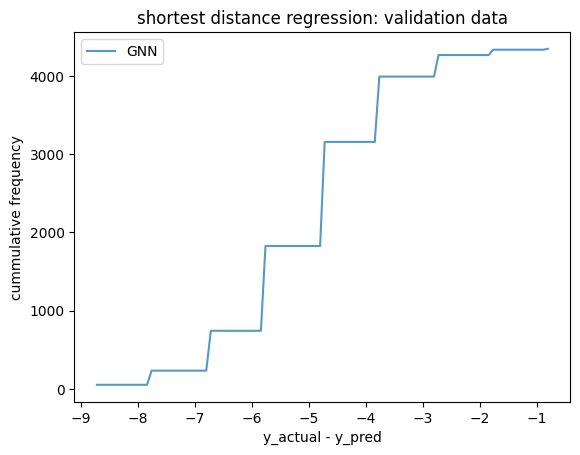

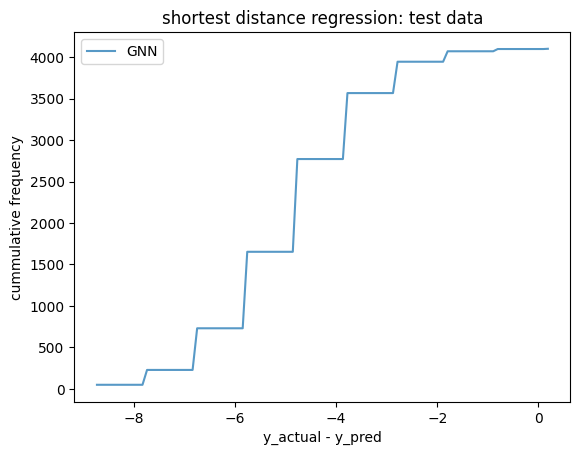

In [54]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,90,0.03125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.4860, Validation Loss (MSE): 0.4649
Epoch: 020, Training Loss (MSE): 0.4860, Validation Loss (MSE): 0.4648
Epoch: 030, Training Loss (MSE): 0.4860, Validation Loss (MSE): 0.4648
Epoch: 040, Training Loss (MSE): 0.4860, Validation Loss (MSE): 0.4648
Epoch: 050, Training Loss (MSE): 0.4860, Validation Loss (MSE): 0.4648
Test Loss (MSE): 0.490344


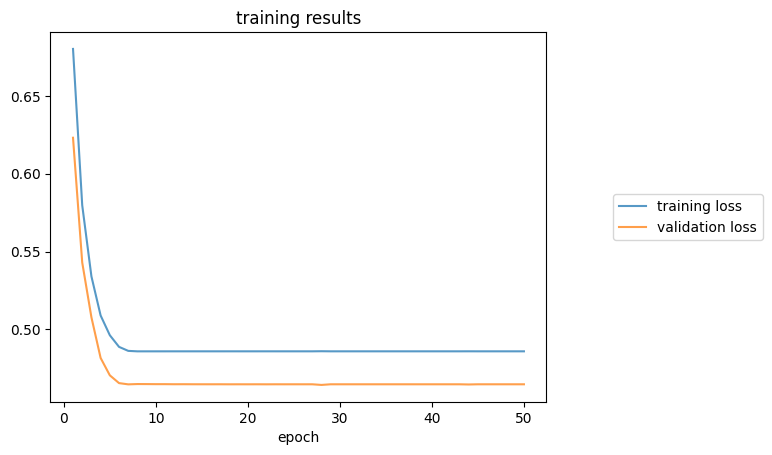

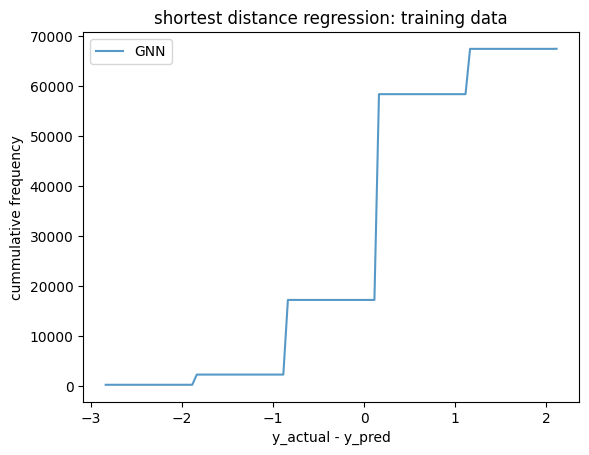

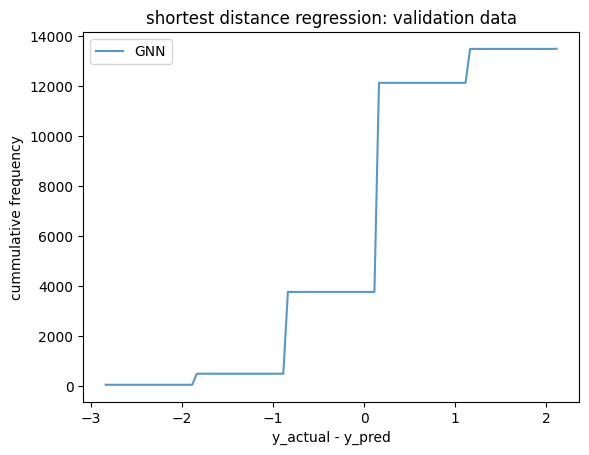

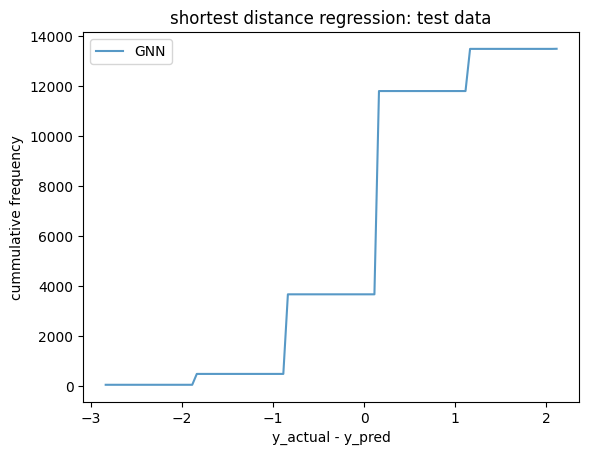

In [55]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,270,0.03125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3093, Validation Loss (MSE): 0.3135
Epoch: 020, Training Loss (MSE): 0.3086, Validation Loss (MSE): 0.3101
Epoch: 030, Training Loss (MSE): 0.3086, Validation Loss (MSE): 0.3099
Epoch: 040, Training Loss (MSE): 0.3085, Validation Loss (MSE): 0.3099
Epoch: 050, Training Loss (MSE): 0.3084, Validation Loss (MSE): 0.3099
Test Loss (MSE): 0.310054


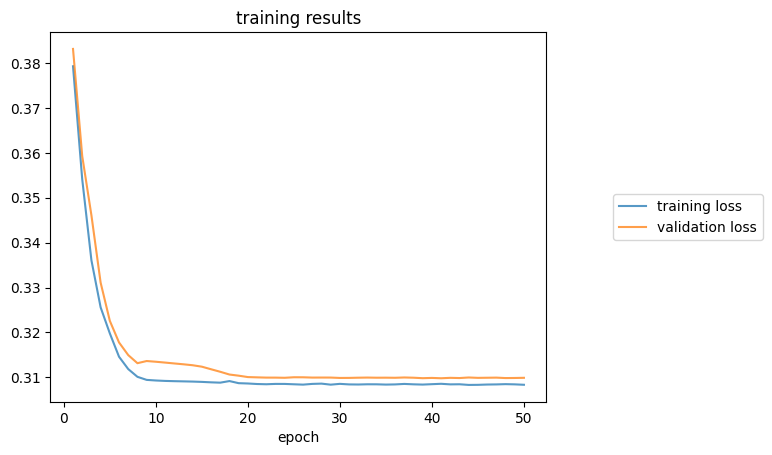

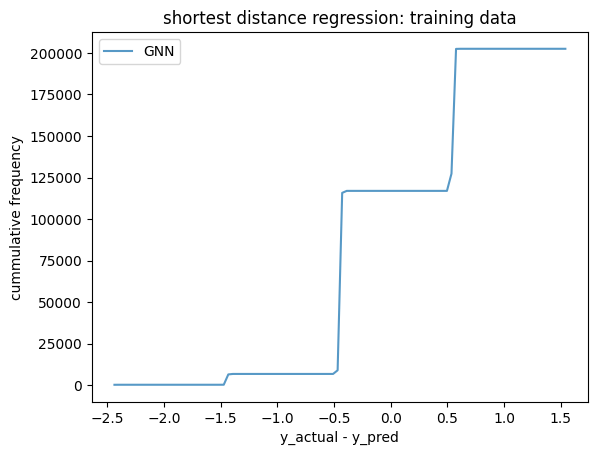

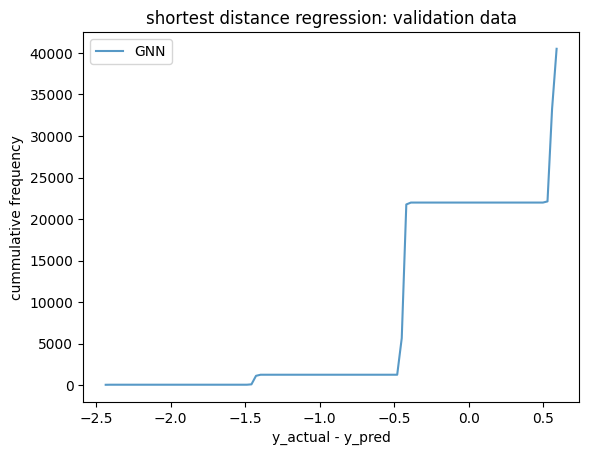

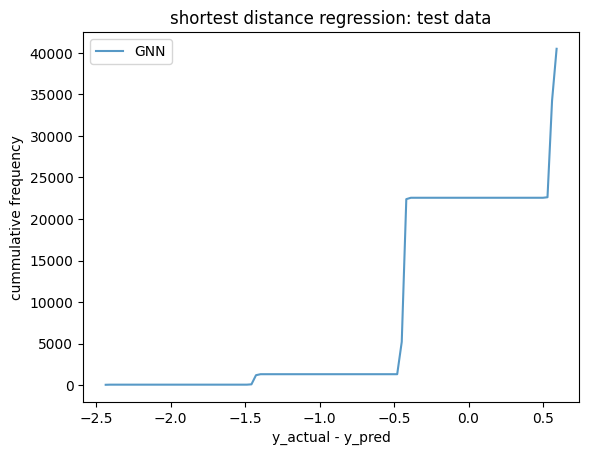

In [56]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,810,0.03125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.1193, Validation Loss (MSE): 0.1251
Epoch: 020, Training Loss (MSE): 0.1183, Validation Loss (MSE): 0.1241
Epoch: 030, Training Loss (MSE): 0.1182, Validation Loss (MSE): 0.1239
Epoch: 040, Training Loss (MSE): 0.1181, Validation Loss (MSE): 0.1239
Epoch: 050, Training Loss (MSE): 0.1181, Validation Loss (MSE): 0.1239
Test Loss (MSE): 0.119808


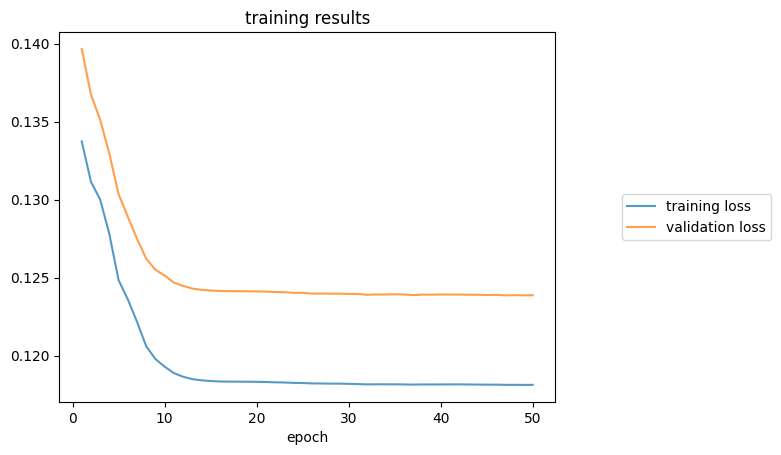

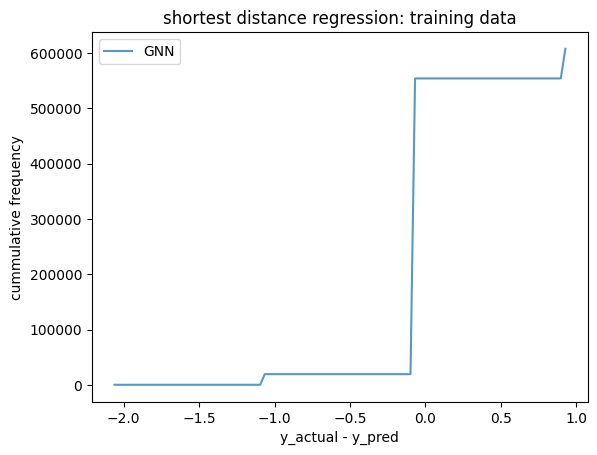

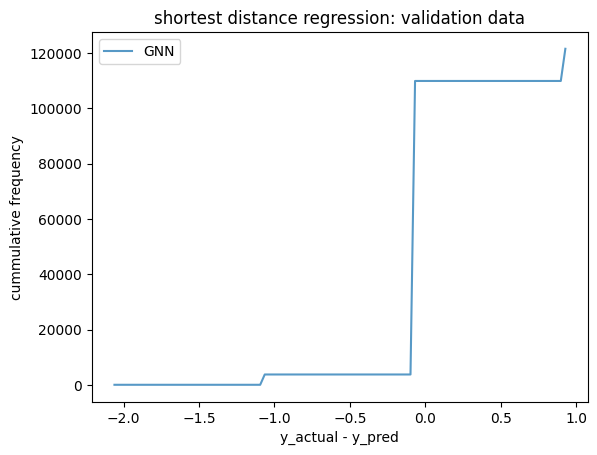

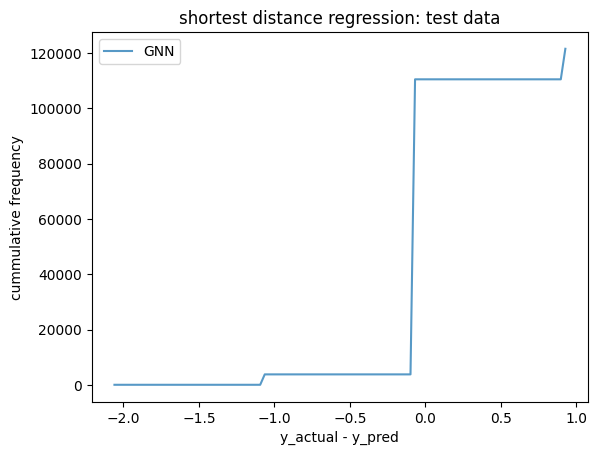

In [57]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,2430,0.03125)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Epoch: 020, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Epoch: 030, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Epoch: 040, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Epoch: 050, Training Loss (MSE): 0.2500, Validation Loss (MSE): 0.2500
Test Loss (MSE): 0.250000


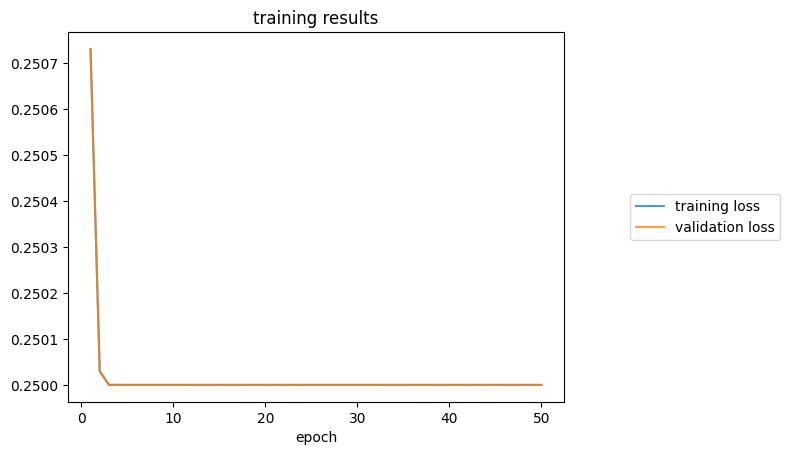

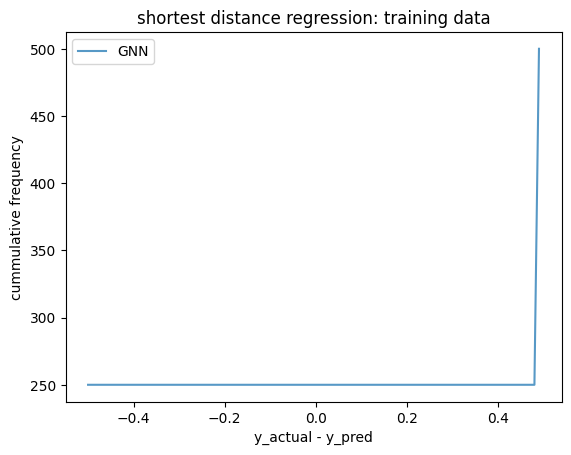

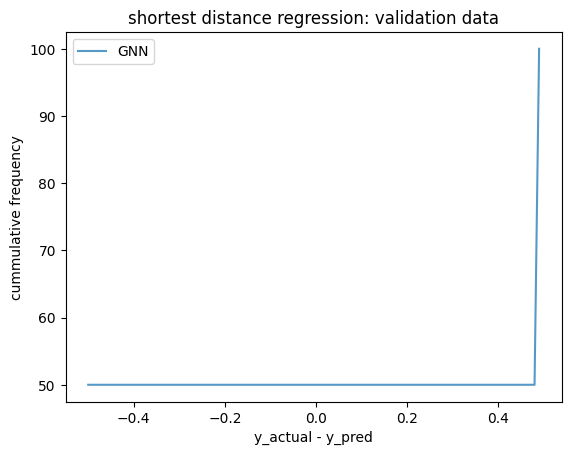

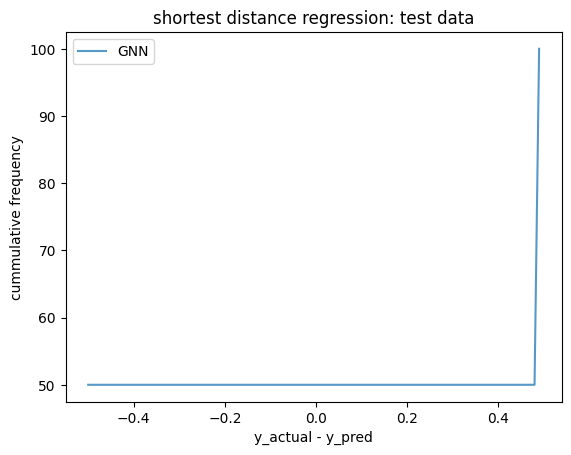

In [58]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,10,0.015625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 5.6602, Validation Loss (MSE): 4.7219
Epoch: 020, Training Loss (MSE): 2.5562, Validation Loss (MSE): 1.9582
Epoch: 030, Training Loss (MSE): 2.3059, Validation Loss (MSE): 1.8974
Epoch: 040, Training Loss (MSE): 1.8579, Validation Loss (MSE): 1.4640
Epoch: 050, Training Loss (MSE): 2.1674, Validation Loss (MSE): 1.7650
Test Loss (MSE): 12.759026


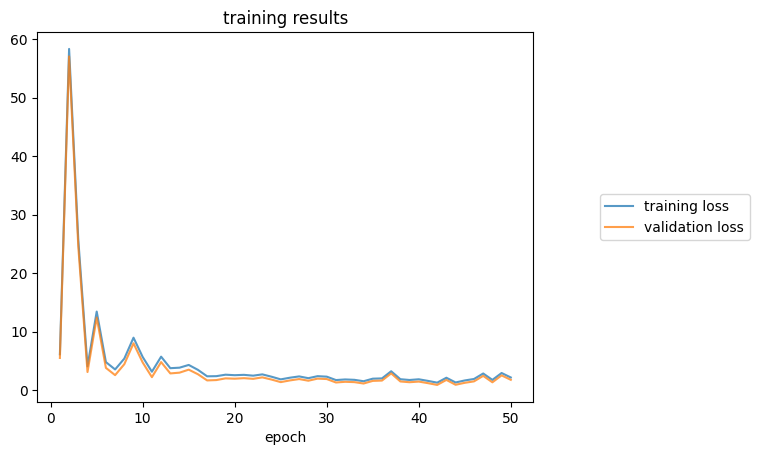

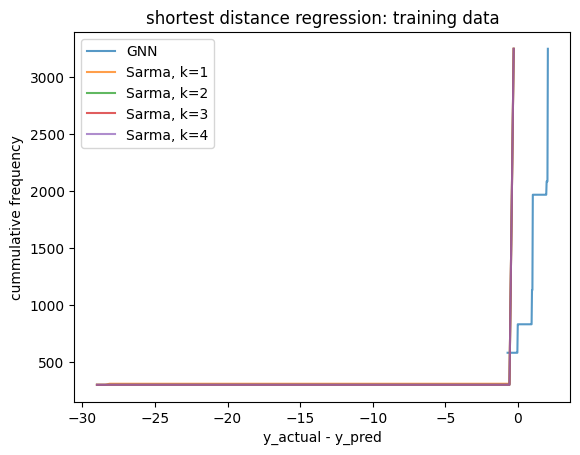

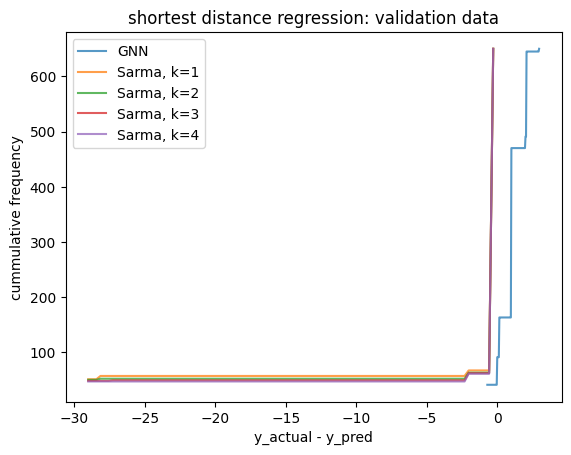

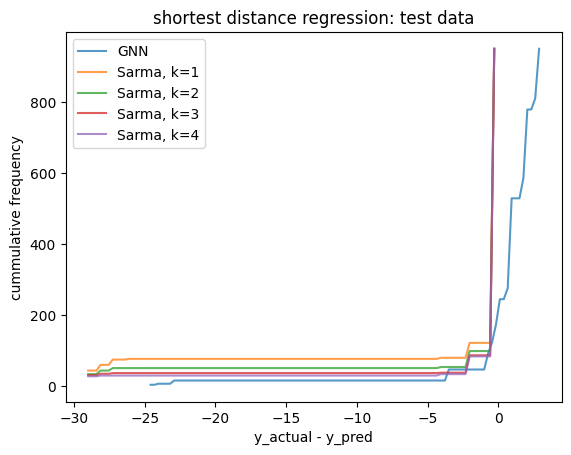

In [59]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,30,0.015625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 1161.0338, Validation Loss (MSE): 872.3201
Epoch: 020, Training Loss (MSE): 997.2719, Validation Loss (MSE): 639.2321
Epoch: 030, Training Loss (MSE): 989.1924, Validation Loss (MSE): 626.8868
Epoch: 040, Training Loss (MSE): 980.6188, Validation Loss (MSE): 612.1978
Epoch: 050, Training Loss (MSE): 970.1085, Validation Loss (MSE): 598.9743
Test Loss (MSE): 569.384338


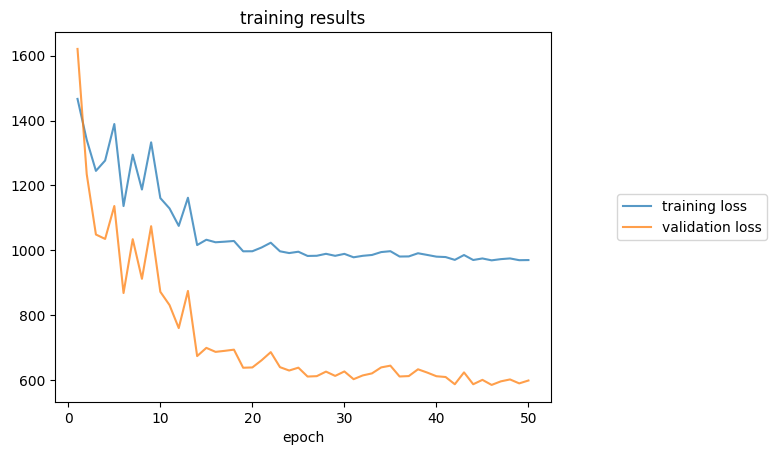

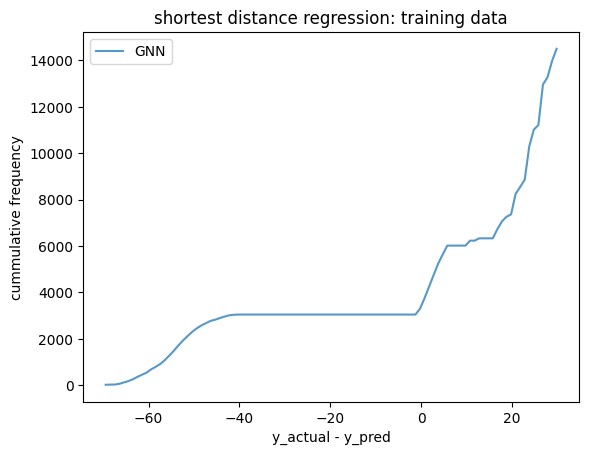

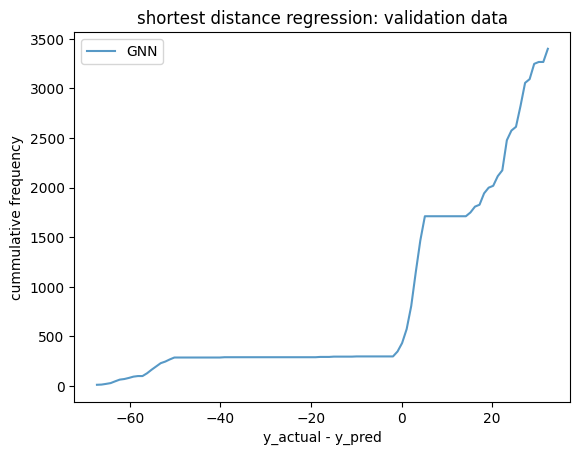

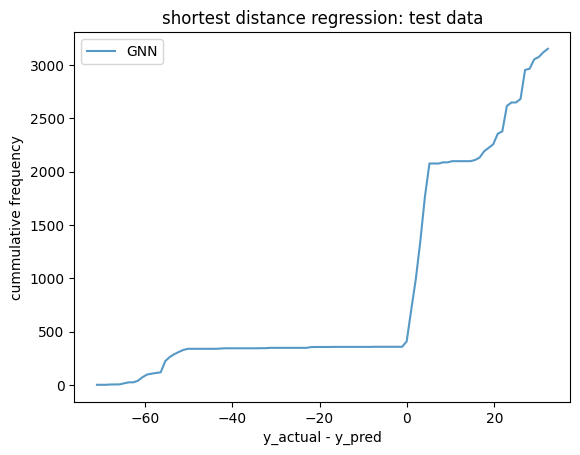

In [60]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,90,0.015625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2256, Validation Loss (MSE): 0.2915
Epoch: 020, Training Loss (MSE): 0.2005, Validation Loss (MSE): 0.2398
Epoch: 030, Training Loss (MSE): 0.2243, Validation Loss (MSE): 0.2609
Epoch: 040, Training Loss (MSE): 0.1944, Validation Loss (MSE): 0.2315
Epoch: 050, Training Loss (MSE): 0.1999, Validation Loss (MSE): 0.2580
Test Loss (MSE): 0.266363


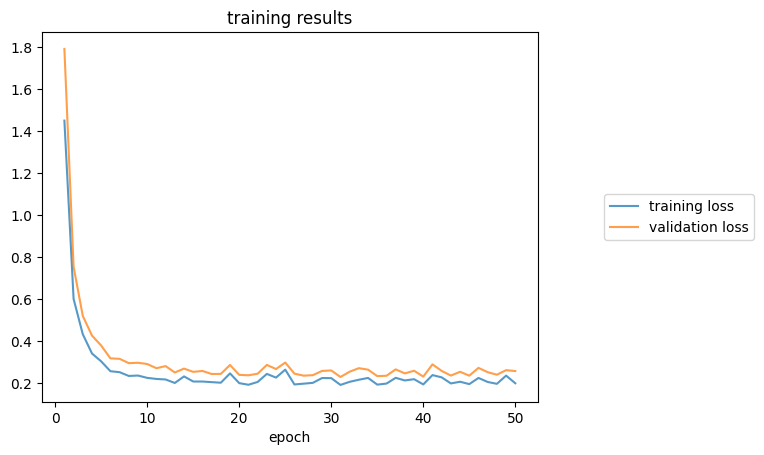

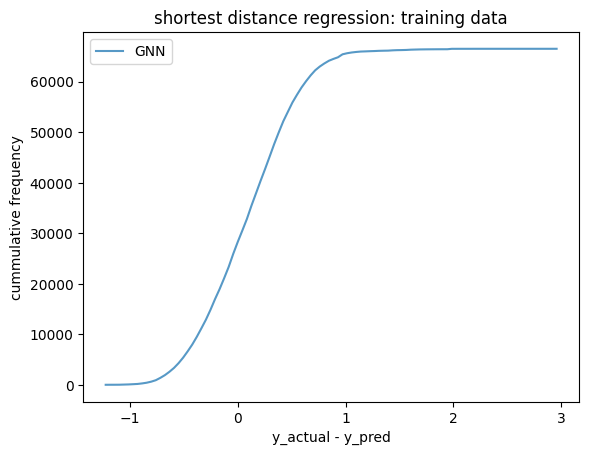

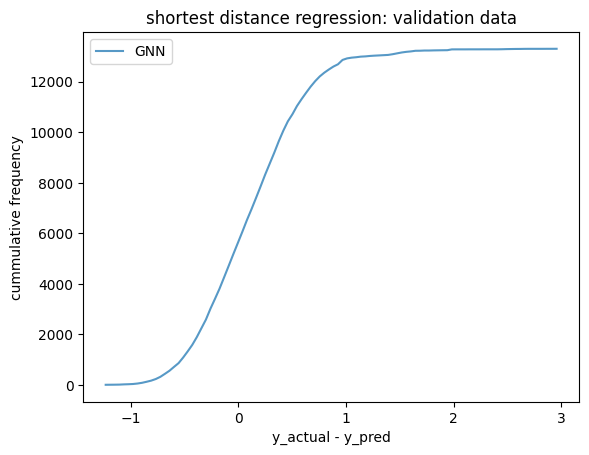

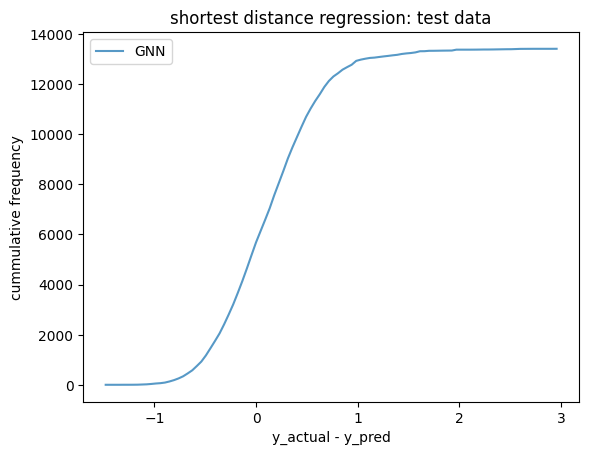

In [61]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,270,0.015625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.3552, Validation Loss (MSE): 0.3388
Epoch: 020, Training Loss (MSE): 0.3551, Validation Loss (MSE): 0.3387
Epoch: 030, Training Loss (MSE): 0.3551, Validation Loss (MSE): 0.3387
Epoch: 040, Training Loss (MSE): 0.3551, Validation Loss (MSE): 0.3387
Epoch: 050, Training Loss (MSE): 0.3551, Validation Loss (MSE): 0.3387
Test Loss (MSE): 0.351601


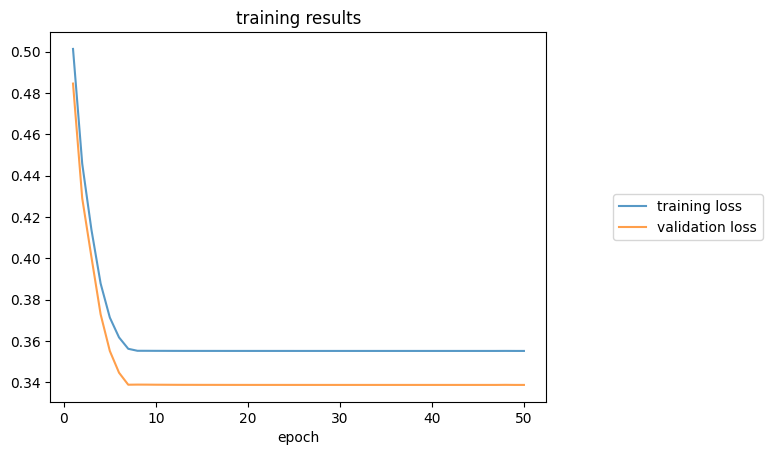

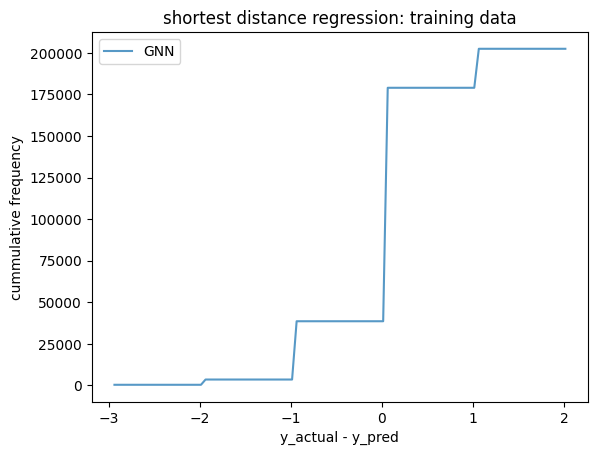

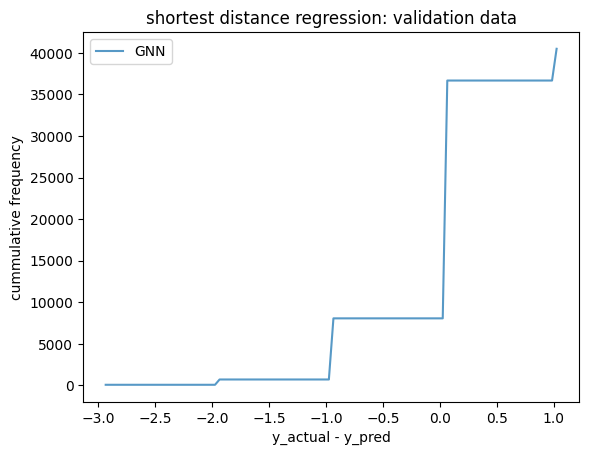

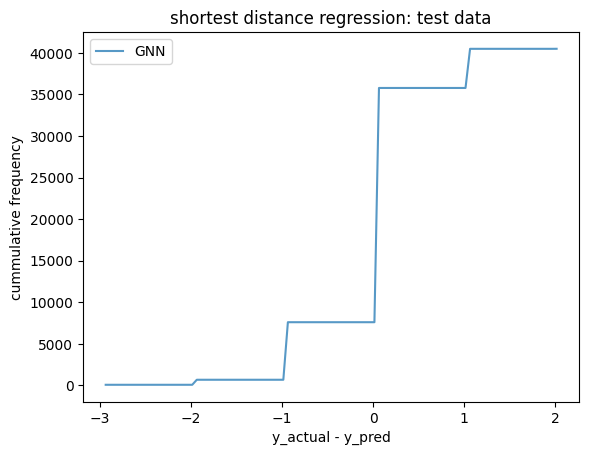

In [62]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,810,0.015625)
run(samples,'gcn','mse','adam',None,50)

GCN(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 8)
  (conv6): GCNConv(8, 1)
  (reLU): ReLU()
)
Epoch: 010, Training Loss (MSE): 0.2836, Validation Loss (MSE): 0.2843
Epoch: 020, Training Loss (MSE): 0.2834, Validation Loss (MSE): 0.2841
Epoch: 030, Training Loss (MSE): 0.2834, Validation Loss (MSE): 0.2841
Epoch: 040, Training Loss (MSE): 0.2834, Validation Loss (MSE): 0.2841
Epoch: 050, Training Loss (MSE): 0.2834, Validation Loss (MSE): 0.2841
Test Loss (MSE): 0.282185


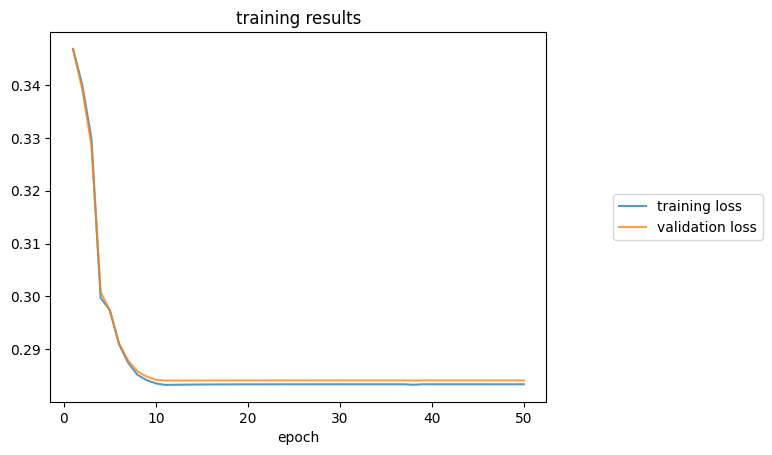

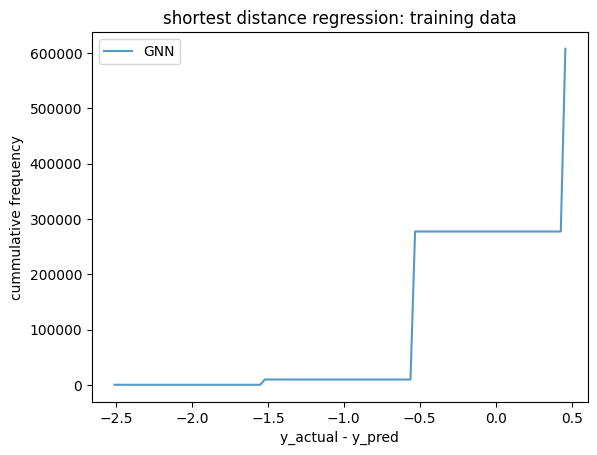

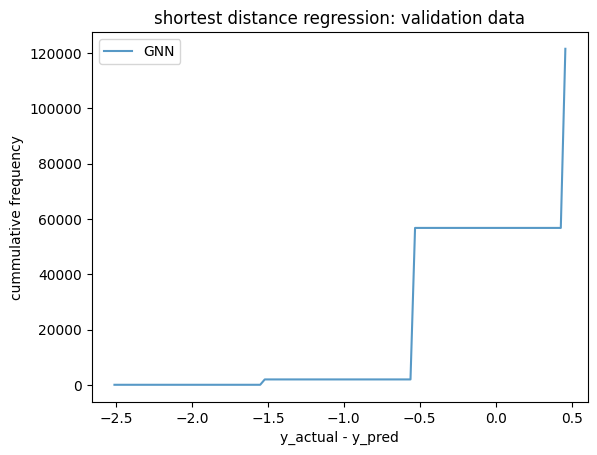

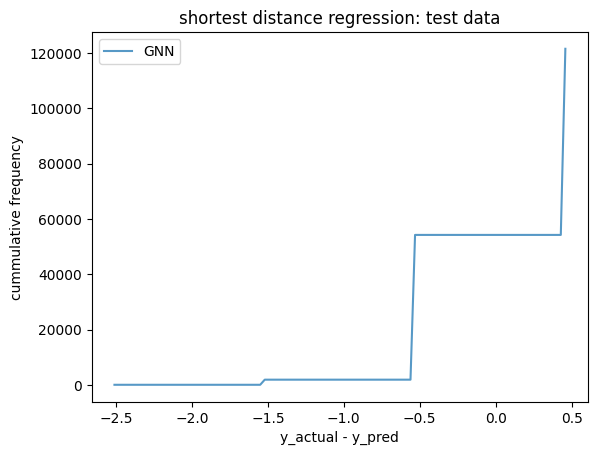

In [63]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,2430,0.015625)
run(samples,'gcn','mse','adam',None,50)

In [64]:
samples = generateSamples_closestPoints(250,50,50,1,ErdosRenyiGraph,2430,0.5)
run(samples,'gcn','mse','adam',None,50)